### Imports

In [1]:
import sys
import time
import os
import traceback
import warnings
import requests
from pathlib import Path
from bs4 import BeautifulSoup
from typing import Union, List
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.io as pio

pio.renderers.default = "notebook"
import plotly.graph_objs as go
from plotly.subplots import make_subplots


import statsmodels.api as sm
from scipy.stats import linregress
from scipy.signal import cheby1, filtfilt, savgol_filter
from scipy.optimize import curve_fit, minimize
from scipy.signal import find_peaks
from sklearn.linear_model import RANSACRegressor, LinearRegression


CURRENT_DIR = Path(os.getcwd())


# Move to the root directory


ROOT_DIR = CURRENT_DIR.parents[0]  # Adjust the number based on your folder structure


# Add the root directory to the system path


sys.path.append(str(ROOT_DIR))


# Import the importlib module


import importlib


# import function implementations
import stst_urls


# Reload the modules


importlib.reload(stst_urls)


# Re-import the functions


from stst_urls import GTX_URL

ANALYSIS_RUN_NAME = "ITH_v2_3"
DECODER_FILE = "QC WAFER_LAYOUT 24Dec.csv"  # legacy
SUBARU_DECODER = "QC WAFER_LAYOUT 24Dec.csv"
HALO_DECODER = "HALO_DECODER_NE-rev1_1 logic_coords_annotated.csv"
DECODER_FILE_PATH = ROOT_DIR / "decoders" / DECODER_FILE  # legacy
RESULTS_FILE_PATH = ROOT_DIR / "results"
EXPORTS_FILEPATH = ROOT_DIR / "exports"


# Create the exports folder if it doesn't exist
if not os.path.exists(EXPORTS_FILEPATH):
    os.makedirs(EXPORTS_FILEPATH)
# print(EXPORTS_FILEPATH)

# Input Raw File and Decoder File

In [2]:
def liv_raw_filelink_finder(
    wafer_codes, fileserver_link: str, product_code: Union[str, List[str]] = "QC", select_earliest: bool = False
):
    if isinstance(product_code, str):
        product_codes = [product_code]
    else:
        product_codes = product_code

    subdirectory_map = {wafer_code: None for wafer_code in wafer_codes}

    for code in product_codes:
        base_url = f"{fileserver_link}{code}/"
        print(f"Checking fileserver link: {base_url}")

        try:
            response = requests.get(base_url, verify=False)
            soup = BeautifulSoup(response.content, "html.parser")
            links = soup.find_all("a")

            for wafer_code in wafer_codes:
                if subdirectory_map[wafer_code] is not None:
                    continue
                for link in links:
                    href = link.get("href")
                    if href and wafer_code in href:
                        subdirectory_map[wafer_code] = base_url + href
                        break
        except Exception as e:
            print(f"Failed to fetch from {base_url}: {e}")

    wafer_records = []
    missing = []

    for wafer_code in wafer_codes:
        subdirectory_url = subdirectory_map.get(wafer_code)

        if not subdirectory_url:
            missing.append(wafer_code)
            continue

        try:
            response = requests.get(subdirectory_url, verify=False)
            soup = BeautifulSoup(response.content, "html.parser")
            links = soup.find_all("a")
        except Exception as e:
            print(f"Failed to access subdir for {wafer_code}: {e}")
            missing.append(wafer_code)
            continue

        cmp = (lambda a, b: a < b) if select_earliest else (lambda a, b: a > b)
        init_time = "99999999999999" if select_earliest else ""

        latest_file = None
        latest_cod_file = None
        latest_degradation_file = None
        latest_time = init_time
        latest_cod_time = init_time
        latest_degradation_time = init_time
        machine_name = None
        proc_cod70 = None
        proc_cod250 = None
        proc_cod_base = None

        for link in links:
            href = link.get("href")
            if not href:
                continue

            if "RAW" in href:
                time_str = href[-18:-4]
                if not machine_name:
                    machine_name = href[:6]

                if "COD250" in href:
                    if cmp(time_str, latest_cod_time):
                        latest_cod_time = time_str
                        latest_cod_file = subdirectory_url + href

                elif "COD70" in href:
                    if cmp(time_str, latest_degradation_time):
                        latest_degradation_time = time_str
                        latest_degradation_file = subdirectory_url + href

                else:
                    if cmp(time_str, latest_time):
                        latest_time = time_str
                        latest_file = subdirectory_url + href

            elif "processed" in href and "COD" in href:
                full_url = subdirectory_url + href
                if "COD250" in href and proc_cod250 is None:
                    proc_cod250 = full_url
                elif "COD70" in href and proc_cod70 is None:
                    proc_cod70 = full_url
                elif "COD" in href and "COD250" not in href and "COD70" not in href and proc_cod_base is None:
                    proc_cod_base = full_url

        if latest_file is None:
            missing.append(wafer_code)
            continue  # Skip wafers with no valid RAW file

        wafer_records.append(
            {
                "wafer_code": wafer_code,
                "file_url": latest_file,
                "file_cod_url": latest_cod_file,
                "file_degradation_url": latest_degradation_file,
                "file_time": latest_time if latest_file else None,
                "file_cod_time": latest_cod_time if latest_cod_file else None,
                "file_degradation_time": latest_degradation_time if latest_degradation_file else None,
                "machine": machine_name,
                "proc_cod70_url": proc_cod70,
                "proc_cod250_url": proc_cod250,
                "proc_cod_base_url": proc_cod_base,
            }
        )

        # Optional: If you want to keep all entries even with missing data, comment out the `continue` above
        # and always append to wafer_records, just using None values

    return wafer_records, missing


wafer_codes = [
    #     "NEHRH",
    #     "NEHSI",
    #     "NEHUF",
    #     "NEHUT",
    #     "NEHWK",
    #     "NEHXF",
    #     "NEHXT",
    #     "NEHXV",
    #     "NEHXW",
    #     "NEHXX",
    #     "NEHXY",
    #     "NEHXZ",
    #     "NEHY0",
    #     "NEHY1",
    #     "NEHY2",
    #     "NEHY3",
    #     "NEHY5",
    #     "NEHY6",
    #     "NEHY7",
    #     "NEHY8",
    #     "NEHY9",
    #     "NEHYD",
    #     "NEHYE",
    #     "NEHYF",
    #     "NEHYJ",
    #     "NEHYK",
    #     "NEHYL",
    #     "NEHYM",
    #     "NEHYN",
    #     "NEHYO",
    #     "NEHYP",
    #     "NEHYQ",
    #     "NEHZ3",
    #     "NEHZ4",
    #     "NEHZ6",
    #     "NEHZ7",
    #     "NEHZA",
    #     "NEHZD",
    #     "NEHZE",
    #     "NEHZF",
    #     "NEHZG",
    #     "NEHZH",
    #     "NEHZI",
    #     "NEHZK",
    #     "NEHZM",
    #     "NEHZP",
    #     "NEHZS",
    #     "NEHZV",
    #     "NEHZX",
    #     "NEHZY",
    #     "NEHZZ",
    #     "NEI00",
    #     "NEI01",
    #     "NEI02",
    #     "NEI03",
    #     "NEI04",
    #     "NEI06",
    #     "NEI07",
    #     "NEI08",
    #     "NEI0B",
    #     "NEI0C",
    #     "NEI0E",
    #     "NEI0H",
    #     "NEI0I",
    #     "NEI0J",
    #     "NEI0N",
    #     "NEI0O",
    #     "NEI0P",
    #     "NEI0R",
    #     "NEI0T",
    #     "NEI0X",
    #     "NEI0Z",
    #     "NEI13",
    #     "NEI16",
    #     "NEI1I",
    #     "NKHMF",
    #     "NKHMG",
    #     "NKHMP",
    #     "NKHMQ",
    #     "NKHMR",
    #     "NKHMS",
    #     "NKHND",
    #     "NKHNI",
    #     "NKHNJ",
    #     "NKHNK",
    #     "NKHNL",
    #     "NKHO2",
    #     "NKHO5",
    #     "NKHOG",
    #     "NKHOH",
    #     "NKHOO",
    #     "NKHOQ",
    #     "NKHOS",
    #     "NKHP6",
    #     "NKHP7",
    #     "NKHP8",
    #     "NKHP9",
    #     "NKHPA",
    #     "NKHPB",
    #     "NKHPC",
    #     "NKHPD",
    #     "NKHPE",
    #     "NKHPK",
    #     "NKHPM",
    #     "NKHPP",
    #     "NKHPQ",
    #     "NKHPR",
    #     "NKHPS",
    #     "NKHPT",
    #     "NKHQ4",
    #     "NKHQ5",
    #     "NKHQ7",
    #     "NKHQ8",
    #     "NKHQ9",
    #     "NKHQA",
    #     "NKHQB",
    #     "NKHQC",
    #     "NKHQD",
    #     "NKHQE",
    #     "NKHQG",
    #     "NKHQH",
    #     "NKHQI",
    #     "NKHQJ",
    #     "NKHQK",
    #     "NKHQN",
    #     "NKHQU",
    #     "NKHQX",
    #     "NKHQY",
    #     "NKHQZ",
    #     "NKHR0",
    #     "NKHR2",
    #     "NKHR3",
    #     "NKHR5",
    #     "NKHR8",
    #     "NKHR9",
    #     "NKHRG",
    #     "NKHRH",
    #     "NKHRN",
    #     "NKHS9",
    #     "NKHSB",
    #     "NKHSE",
    #     "NKHSI",
    #     "NKHSL",
    #     "NKHSM",
    #     "NKHSO",
    #     "NKHSP",
    #     "NKHSR",
    #     "NKHSS",
    #     "NKHST",
    #     "NKHSU",
    #     "NKHSW",
    #     "NKHT4",
    #     "NKHT8",
    #     "NKHTA",
    #     "NKHTB",
    #     "NKHTC",
    #     "NKHTD",
    #     "NKHTH",
    #     "NKHTI",
    #     "NKHTJ",
    #     "NKHTK",
    #     "NKHTP",
    #     "NKHTQ",
    #     "NKHTR",
    #     "NKHU6",
    #     "NKHU9",
    #     "NKHUB",
    #     "NKHUC",
    #     "NKHUF",
    #     "NKHUG",
    #     "NKHUI",
    #     "NKHUL",
    #     "NKHUM",
    #     "NKHUO",
    #     "NKHUQ",
    #     "NKHUR",
    #     "NKHUT",
    #     "NKHUY",
    #     "NKHV1",
    #     "NKHV2",
    #     "NKHV4",
    #     "NKHV6",
    #     "NKHV7",
    #     "NKHV8",
    #     "NKHVA",
    #     "NKHVB",
    #     "NKHVC",
    #     "NKHVG",
    #     "NKHVI",
    #     "NKHVL",
    #     "NKHVM",
    #     "NKHVP",
    #     "NKHVR",
    #     "NKHWN",
    #     "NKHWR",
    #     "NKHX8",
    #     "NKHXA",
    #     "NVIHY",
    #     "NVIHZ",
    #     "NVII0",
    #     "NVII1",
    #     "NVII2",
    #     "NVII4",
    #     "NVII5",
    #     "NVII7",
    #     "NVII9",
    #     "NVIIA",
    #     "NVIIB",
    #     "NVIIC",
    #     "NVIID",
    #     "NVIIE",
    #     "NVIIG",
    #     "NVIIH",
    #     "NVIII",
    #     "NVIIJ",
    #     "NVIIL",
    #     "NVIIY",
    #     "NVIIZ",
    #     "NVIJ0",
    #     "NVIJ1",
    #     "NVIJ2",
    #     "NVIJ3",
    #     "NVIJ6",
    #     "NVIJA",
    #     "NVIJB",
    #     "NVIJC",
    #     "NVIJT",
    #     "NVIJV",
    #     "NVIJW",
    #     "NVIK0",
    #     "NVIK1",
    #     "NVIK3",
    #     "NVIK8",
    #     "NVIKB",
    #     "NVIKC",
    #     "NVIKD",
    #     "NVIKE",
    #     "NVIKS",
    #     "NVIKT",
    #     "NVIKV",
    #     "NVIKW",
    #     "NVIKY",
    #     "NVIKZ",
    #     "NVIL0",
    #     "NVILA",
    #     "NVILB",
    #     "NVILD",
    #     "NVILE",
    #     "NVILF",
    #     "NVILG",
    #     "NVILH",
    #     "NVILI",
    #     "NVILJ",
    #     "NVILK",
    #     "NVILM",
    #     "NVILN",
    #     "NVILO",
    #     "NVILP",
    #     "NVILR",
    #     "NVILS",
    #     "NVILT",
    #     "NVILU",
    #     "NVILW",
    #     "NVILX",
    #     "NVILY",
    #     "NVILZ",
    #     "NVIM2",
    #     "NVIM4",
    #     "NVIM5",
    #     "NVIM6",
    #     "NVIM7",
    #     "NVIM8",
    #     "NVIM9",
    #     "NVIMA",
    #     "NVIMC",
    #     "NVIMD",
    #     "NVIME",
    #     "NVIMF",
    #     "NVIMG",
    #     "NVIMJ",
    #     "NVIMK",
    #     "NVIML",
    #     "NVIMM",
    #     "NVIMN",
    #     "NVIMO",
    #     "NVIMQ",
    #     "NVIN2",
    #     "NVIN3",
    #     "NVIN4",
    #     "NVIN6",
    #     "NVIN7",
    #     "NVIN9",
    #     "NVINM",
    #     "NVINS",
    "QCHUU",
    "QCHUW",
    "QCHUY",
    "QCHUZ",
    "QCHV0",
    "QCHV7",
    "QCHV8",
    "QCHV9",
    "QCHVB",
    "QCHVD",
    "QCHVF",
    "QCHVG",
    "QCHVH",
    "QCHVI",
    "QCHVM",
    "QCHVP",
    "QCHVQ",
    "QCHVR",
    "QCHVS",
    "QCHVT",
    "QCHVV",
    "QCHVW",
    "QCHVY",
    "QCHVZ",
    "QCHW0",
    "QCHW1",
    "QCHW2",
    "QCHW3",
    "QCHW4",
    "QCHW5",
    "QCHW6",
    "QCHW8",
    "QCHW9",
    "QCHWA",
    "QCHWB",
    "QCHWC",
    "QCHWD",
    "QCHWE",
    "QCHWG",
    "QCHWI",
    "QCHWJ",
    "QCHWK",
    "QCHWM",
    "QCHWO",
    "QCHWQ",
    "QCHWS",
    "QCHWV",
    "QCHWW",
    "QCHWX",
    "QCHWY",
    "QCHWZ",
    "QCHX0",
    "QCHX1",
    "QCHX2",
    "QCHX3",
    "QCHX4",
    "QCHX6",
    "QCHX8",
    "QCHXA",
    "QCHXB",
    "QCHXC",
    "QCHXD",
    "QCHXE",
    "QCHXF",
    "QCHXG",
    "QCHXI",
    "QCHXJ",
    "QCHXK",
    "QCHXL",
    "QCHXM",
    "QCHXN",
    "QCHXP",
    "QCHXQ",
    "QCHXS",
    "QCHXV",
    "QCHXW",
    "QCHXX",
    "QCHXY",
    "QCHXZ",
    "QCHY0",
    "QCHY2",
    "QCHY3",
    "QCHY5",
    "QCHY6",
    "QCHY8",
    "QCHY9",
    "QCHYB",
    "QCHYC",
    "QCHYD",
    "QCHYE",
    "QCHYF",
    "QCHYH",
    "QCHYK",
    "QCHYM",
    "QCHYN",
    "QCHYP",
    "QCHYR",
    "QCHYS",
    "QCHYT",
    "QCHYU",
    "QCHYW",
    "QCHYY",
    "QCHYZ",
    "QCHZ0",
    "QCHZ1",
    "QCHZ4",
    "QCHZ5",
    "QCHZ7",
    "QCHZ8",
    "QCHZ9",
    "QCHZA",
    "QCHZC",
    "QCHZD",
    "QCHZE",
    "QCHZF",
    "QCHZG",
    "QCHZH",
    "QCHZI",
    "QCHZK",
    "QCHZN",
    "QCHZO",
    "QCHZP",
    "QCHZR",
    "QCHZS",
    "QCHZU",
    "QCHZX",
    "QCHZY",
    "QCHZZ",
    "QCI02",
    "QCI03",
    "QCI04",
    "QCI06",
    "QCI07",
    "QCI0A",
    "QCI0D",
    "QCI0F",
    "QCI0G",
    "QCI0H",
    "QCI0J",
    "QCI0K",
    "QCI0L",
    "QCI0M",
    "QCI0N",
    "QCI0O",
    "QCI0P",
    "QCI0Q",
    "QCI12",
    "QCI13",
    "QCI15",
    "QCI19",
    "QCI1A",
    "QCI1B",
    "QCI1D",
    "QCI1E",
    "QCI1F",
    "QCI1G",
    "QCI1J",
    "QCI1M",
    "QCI1N",
    "QCI1O",
    "QCI1Q",
    "QCI1R",
    "QCI1S",
    "QCI1U",
    "QCI1V",
    "QCI1W",
    "QCI1X",
    "QCI1Y",
    "QCI20",
    "QCI21",
    "QCI22",
    "QCI23",
    "QCI24",
    "QCI26",
    "QCI27",
    "QCI28",
    "QCI2B",
    "QCI2C",
    "QCI2D",
    "QCI2E",
    "QCI2G",
    "QCI2J",
    "QCI2K",
    "QCI2N",
    "QCI2P",
    "QCI2Q",
    "QCI2R",
    "QCI2T",
    "QCI2V",
    "QCI2W",
    "QCI2X",
    "QCI30",
    "QCI32",
    "QCI35",
    "QCI36",
    "QCI37",
    "QCI3A",
    "QCI3D",
    "QCI3F",
    "QCI3L",
    "QCI3M",
    "QCI3N",
    "QCI3Q",
    "QCI3R",
    "QCI3S",
    "QCI3T",
    "QCI3V",
    "QCI3W",
    "QCI3X",
    "QCI3Y",
    "QCI3Z",
    "QCI41",
    "QCI42",
    "QCI44",
    "QCI45",
    "QCI46",
    "QCI47",
    "QCI48",
    "QCI4A",
    "QCI4B",
    "QCI4C",
    "QCI4I",
    "QCI4M",
    "QCI55",
    "QCI5D",
    "QCI5H",
    #     "QDHHH",
    #     "QDHHI",
    #     "QDHHJ",
    #     "QDHHL",
    #     "QDHHO",
    #     "QDHHP",
    #     "QDHHR",
    #     "QDHHY",
    #     "QDHI0",
    #     "QDHI1",
    #     "QDHI4",
    #     "QDHI5",
    #     "QDHI7",
    #     "QDHI8",
    #     "QDHID",
    #     "QDHIE",
    #     "QDHIQ",
    #     "QDHIS",
    #     "QDHIV",
    #     "QDHIW",
    #     "QDHIX",
    #     "QDHIY",
    #     "QDHJ1",
    #     "QDHJ2",
    #     "QDHJ4",
    #     "QDHJ5",
    #     "QDHJ6",
    #     "QDHJ8",
    #     "QDHJC",
    #     "QDHJI",
    #     "QDHJJ",
    #     "QDHJM",
    #     "QDHJN",
    #     "QDHJO",
    #     "QDHJP",
    #     "QDHJQ",
    #     "QDHJR",
    #     "QDHJS",
    #     "QDHJT",
    #     "QDHJU",
    #     "QDHJW",
    #     "QDHJZ",
    #     "QDHK1",
    #     "QDHK2",
    #     "QDHK3",
    #     "QDHK4",
    #     "QDHK5",
    #     "QDHK6",
    #     "QDHK7",
    #     "QDHK9",
    #     "QDHKA",
    #     "QDHKB",
    #     "QDHKC",
    #     "QDHKD",
    #     "QDHKE",
    #     "QDHKF",
    #     "QDHKJ",
    #     "QDHL1",
    #     "QDHL2",
    #     "QDHL3",
    #     "QDHL4",
    #     "QDHL5",
    #     "QDHL6",
    #     "QDHL7",
    #     "QDHL9",
    #     "QDHLA",
    #     "QDHLB",
    #     "QDHLC",
    #     "QDHLE",
    #     "QDHLF",
    #     "QDHLG",
    #     "QDHLH",
    #     "QDHLI",
    #     "QDHLJ",
    #     "QDHLK",
    #     "QDHLM",
    #     "QDHLN",
    #     "QDHLO",
    #     "QDHLQ",
    #     "QDHLR",
    #     "QDHLT",
    #     "QDHLU",
    #     "QDHLV",
    #     "QDHLW",
    #     "QDHLX",
    #     "QDHLZ",
    #     "QDHM0",
    #     "QDHM1",
    #     "QDHM2",
    #     "QDHM4",
    #     "QDHM5",
    #     "QDHM6",
    #     "QDHM7",
    #     "QDHM8",
    #     "QDHM9",
    #     "QDHMB",
    #     "QDHMC",
    #     "QDHME",
    #     "QDHMF",
    #     "QDHMG",
    #     "QDHMK",
    #     "QDHML",
    #     "QDHMM",
    #     "QDHMO",
    #     "QDHMP",
    #     "QDHMQ",
    #     "QDHMR",
    #     "QDHMS",
    #     "QDHMT",
    #     "QDHMU",
    #     "QDHMV",
    #     "QDHMW",
    #     "QDHMX",
    #     "QDHN0",
    #     "QDHN1",
    #     "QDHN2",
    #     "QDHN4",
    #     "QDHN5",
    #     "QDHN6",
    #     "QDHN7",
    #     "QDHN8",
    #     "QDHNA",
    #     "QDHNC",
    #     "QDHNF",
    #     "QDHNI",
    #     "QDHOB",
    #     "QDHOJ",
    #     "QDHP1",
]  # List of wafer codes


warnings.filterwarnings("ignore")

In [4]:
wafer_codes = [
    # "QCHWV",
    "QCHX0",
    "QCHX1",
    # "QCHX2",
    "QCHX8",
    # "QCHY5",
    # "QCHYH",
    "QCHYT",
    # "QCI0J",
    # "QCI0L",
    # "QCI1U",
    "QCI1V",
    "QCI3T",
    # "QCI3W",
]


print(f"Number of Wafers: {len(wafer_codes)}")


wafer_records, missing_wafers = liv_raw_filelink_finder(wafer_codes, GTX_URL, ["NV", "QD", "QC"], select_earliest=False)

for record in wafer_records:
    print(record["wafer_code"], record["file_url"])


file_urls = [w["file_url"] for w in wafer_records]
wafer_codes = [w["wafer_code"] for w in wafer_records]


# DEBUG: INPUT LINKS TO OTHER GTX FILES HERE


# file_urls = [


#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_DNS-LIVTKCOD_LCRVCOD250-DNS_RAW20250227044906.CSV",


#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_LIVBLTKCOD_COD250-DNS_RAW20250228082707.CSV",


#     "https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/QCHWQ/LIV_53_QCHWQ_LIVBLTKCOD_COD250-DNS_RAW20250311164324.CSV",


# ]


# print(file_urls)

Number of Wafers: 6


NameError: name 'liv_raw_filelink_finder' is not defined

# General Processing Functions

Some predefined functions that can be used outside of ITH

In [3]:
def basic_sweep_analysis(df):
    """
    Compute first and second order differentials for voltage (Vf) and photodiode signal (PD)
    while ensuring calculations remain per device.
    Additionally, compute min and max PD per touchdown and clone max PD across the sweep.
    """
    df["dV/dI"] = df.groupby("TOUCHDOWN")["Vf"].diff()
    df["dP/dI"] = df.groupby("TOUCHDOWN")["PD"].diff()
    df["d2V/dI2"] = df.groupby("TOUCHDOWN")["dV/dI"].diff()
    df["d2P/dI2"] = df.groupby("TOUCHDOWN")["dP/dI"].diff()

    df["MAX_PD"] = df.groupby("TOUCHDOWN")["PD"].transform("max")
    df["MIN_PD"] = df.groupby("TOUCHDOWN")["PD"].transform("min")
    return df


def flag_no_laser_touchdowns(df_raw_sweeps, max_pd=1):
    """
    Adds a "FLAG" column to df_raw_sweeps, labeling touchdowns as "NO LASER"
    if the max PD value for that touchdown is below 1.
    """
    df_raw_sweeps["FLAG"] = np.nan
    no_laser_touchdowns = df_raw_sweeps.groupby("TOUCHDOWN")["PD"].max()
    no_laser_touchdowns = no_laser_touchdowns[no_laser_touchdowns < max_pd].index
    df_raw_sweeps.loc[df_raw_sweeps["TOUCHDOWN"].isin(no_laser_touchdowns), "FLAG"] = "NO LASER"
    return df_raw_sweeps


# Linear model for line fitting
def linear_model(x, slope, intercept):
    return slope * x + intercept


# Least Absolute Residuals fitting function using L1 norm
def least_absolute_residuals_fit(x, y, model, initial_guess, bounds):
    def objective(params):
        return np.sum(np.abs(model(x, *params) - y))

    result = minimize(objective, initial_guess, bounds=bounds, method="L-BFGS-B", options={"maxiter": 1000})

    residuals = np.abs(model(x, *result.x) - y)
    mean_abs_error = np.mean(residuals)

    return result.x, mean_abs_error

# I_th Processing Functions

- Has a function that finds ith given an input intensity and current array
    - **NB:** find_ith_value_labview is trying to mimic labview more closely, while the find_ith_value is a custom function that finds ith value using a similar but not identical mechanisim
- Calls the find_ith_value function on the multiple lasers in the raw sweep file with evaluate_ITH_on_rawsweep
- Then generates a device level summary using generate_ITH_device_summary_table
- calls this code and exports in the main for loop.

In [4]:
# Gaussian model for fitting
def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


def find_ith_value_labview(intensity, current):
    # try:
    # 1) Trim data to only include values >2 and <=35 mA
    mask_trimmed = (current > 1) & (current <= 34)
    if not np.any(mask_trimmed):
        print("Warning: No data points between 2 and 35 mA.")
        return 0
    current = current[mask_trimmed]
    intensity = intensity[mask_trimmed]

    # 2) Interpolate to double resolution (spacing of 0.5 mA)
    current_interp = np.arange(np.min(current), np.max(current) + 0.1, 0.5)
    intensity_interp = np.interp(current_interp, current, intensity)

    current = current_interp
    intensity = intensity_interp

    # 3) Normalize intensity using min-max scaling (first operation)
    min_intensity = np.min(intensity)
    max_intensity = np.max(intensity)
    intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)

    # 4) Sort data by current to ensure proper processing
    sorted_indices = np.argsort(current)
    current = current[sorted_indices]
    intensity_norm = intensity_norm[sorted_indices]

    # 5) Apply Chebyshev high-pass filter (order 2, ripple 0.1 dB, bandpass 0.15–0.45)
    b, a = cheby1(N=2, rp=0.1, Wn=0.45, btype="lowpass", fs=1)
    filtered_intensity = filtfilt(b, a, intensity_norm)

    # 5a) Initial linear fit via least absolute residuals on filtered data using QuantReg
    X = sm.add_constant(current)  # Adds intercept term
    model = sm.QuantReg(filtered_intensity, X)
    res = model.fit(q=0.5)
    slope_left = res.params[1]
    intercept_left = res.params[0]
    initial_abs_residual_total = np.mean(np.abs(filtered_intensity - res.predict(X)))

    # print(initial_abs_residual_total)
    if initial_abs_residual_total > 1:
        print("Warning: Initial L1 fit residual too high.")
        return 0  # DEBUG: STILL TRY

    # 6) First Savitzky-Golay smoothing (5,1)
    smoothed_intensity = savgol_filter(filtered_intensity, window_length=5, polyorder=1)

    # 7) Second Savitzky-Golay smoothing before differential (3,2)
    smoothed_intensity = savgol_filter(smoothed_intensity, window_length=3, polyorder=2)

    # 8) Compute first derivative (renamed to dL_dI)
    dL_dI = np.gradient(smoothed_intensity, current)

    # 9) Smooth first derivative (6,2)
    smoothed_dL_dI = savgol_filter(dL_dI, window_length=6, polyorder=2)

    # 10) Compute second derivative (renamed to d2L_dI2)
    d2L_dI2 = np.gradient(smoothed_dL_dI, current)

    # 11) Smooth second derivative (6,2)
    smoothed_d2L_dI2 = savgol_filter(d2L_dI2, window_length=6, polyorder=2)

    # 11a) Set negative second derivative values to zero (LabVIEW-like behavior)
    smoothed_d2L_dI2[smoothed_d2L_dI2 < 0] = 0

    # 12) Normalize second derivative and add 0.01
    max_d2L_dI2 = np.max(smoothed_d2L_dI2)
    if max_d2L_dI2 == 0:
        print("Warning: Second derivative all zero after zeroing negatives.")
        return 0
    d2L_dI2_ready = (smoothed_d2L_dI2 / max_d2L_dI2) + 0.01

    # 13) Least Absolute Residuals fitting with initial conditions and bounds
    # --- New logic: Find all peaks above 0.95 ---
    peaks, _ = find_peaks(d2L_dI2_ready, height=0.95)
    if len(peaks) == 0:
        print("Warning: No significant peaks in second derivative.")
        return 0

    # Select the leftmost (lowest current) among the high peaks
    selected_peak_idx = peaks[np.argmin(current[peaks])]
    x0_guess = current[selected_peak_idx]
    a_guess = d2L_dI2_ready[selected_peak_idx]
    sigma_guess = (max(current) - min(current)) / 5
    initial_guess = [a_guess, x0_guess, sigma_guess]

    a_min = 0.1 * np.max(d2L_dI2_ready)
    a_max = 2.0 * np.max(d2L_dI2_ready)
    x0_min = max(10, min(current))
    x0_max = min(30, max(current))
    sigma_min = 0.2
    sigma_max = (x0_max - x0_min) / 2
    bounds = ((a_min, a_max), (x0_min, x0_max), (sigma_min, sigma_max))

    popt, _ = least_absolute_residuals_fit(current, d2L_dI2_ready, gaussian, initial_guess, bounds)
    median_x = popt[1]

    # 14) Validate split point
    if not (2 <= median_x <= 35):
        print("Warning: Gaussian fit split point out of usual bounds.")
        return 0

    # 15) Linear fit on left segment
    left_mask = current <= median_x
    if not np.any(left_mask):
        print("Warning: No data points on the left segment for fitting.")
        return 0
    current_left = current[left_mask]
    intensity_left = intensity_norm[left_mask]
    A_left = np.vstack([current_left, np.ones_like(current_left)]).T
    solution_left, _, _, _ = np.linalg.lstsq(A_left, intensity_left, rcond=None)
    slope_left, intercept_left = solution_left

    # 16) Linear fit on right segment
    right_mask = current > median_x
    if not np.any(right_mask):
        print("Warning: No data points on the right segment for fitting.")
        return 0
    current_right = current[right_mask]
    intensity_right = intensity_norm[right_mask]
    N = 15
    current_right = current_right[:-N]
    intensity_right = intensity_right[:-N]
    if len(current_right) < 10:
        print("Warning: Fewer than 10 data points for stimulated emission fit.")
        return 0
    A_right = np.vstack([current_right, np.ones_like(current_right)]).T
    solution_right, residuals, _, _ = np.linalg.lstsq(A_right, intensity_right, rcond=None)
    slope_right, intercept_right = solution_right

    mse_right = residuals[0] / len(intensity_right)
    if mse_right > 1:
        print("Warning: High MSE in stimulated emission fit.")
        return 0

    # 17) Compute intersection (I_th)
    ith_value = (intercept_right - intercept_left) / (slope_left - slope_right)
    if not (2 <= ith_value <= 35):
        print("Warning: Computed I_th outside bounds normal bounds.")
        return 0  # DEBUG: STILL TRY

    return ith_value

# SE Processing Functions

- Function that finds ith given an input intensity and current array
- takes intensity and current for a laser as an input, and masks the arrays based on the 15 points above ITH
- Fits a line to the points using least squares regression (performant vectorised matrix alogithms) and returns the gradient

In [5]:
def find_slope_efficiency(intensity, current, ith, mse_threshold=1, fitting_range=15):
    intensity = np.asarray(intensity)
    current = np.asarray(current)

    if len(intensity) != len(current):
        print("Warning: Input arrays have different lengths.")
        return 0

    # Index where current just exceeds I_th
    idx_start = np.argmax(current >= ith)
    idx_end = idx_start + fitting_range

    if idx_end > len(current):
        print("Warning: Not enough points after I_th for slope efficiency fit.")
        return 0

    # Mask the relevant region
    x = current[idx_start:idx_end]
    y = intensity[idx_start:idx_end]

    # Least squares fit: Ax = y
    A = np.vstack([x, np.ones_like(x)]).T
    try:
        solution, residuals, _, _ = np.linalg.lstsq(A, y, rcond=None)
        slope, intercept = solution

        if residuals.size > 0:
            mse = residuals[0] / len(x)
            if mse > mse_threshold:
                print(f"Warning: High MSE in slope efficiency fit ({mse:.4f}).")
                return 0

        return slope

    except Exception as e:
        print(f"Error during slope efficiency calculation: {e}")
        return 0

# Series Resistance Functions

- Function that finds Series Resistance (RS) given an input voltage and current array
- takes voltage and current for a laser as an input, and masks the arrays based on the 15 points above ITH
- Fits a line to the points using least squares regression (performant vectorised matrix alogithms) and returns the gradient

In [6]:
def find_series_resistance(voltage, current, ith, mse_threshold=0.5, fitting_range=15):
    voltage = np.asarray(voltage)
    current = np.asarray(current)

    if len(voltage) != len(current):
        print("Warning: Input arrays have different lengths.")
        return 0

    # Index where current just exceeds I_th
    idx_start = np.argmax(current >= ith)
    idx_end = idx_start + fitting_range

    if idx_end > len(current):
        print("Warning: Not enough points after I_th for series resistance fit.")
        return 0

    # Mask the relevant region
    x = current[idx_start:idx_end]
    y = voltage[idx_start:idx_end]

    # Least squares fit: Ax = y
    A = np.vstack([x, np.ones_like(x)]).T
    try:
        solution, residuals, _, _ = np.linalg.lstsq(A, y, rcond=None)
        slope, intercept = solution

        if residuals.size > 0:
            mse = residuals[0] / len(x)
            if mse > mse_threshold:
                print(f"Warning: High MSE in series resistance fit ({mse:.4f}).")
                return 0

        rs_ohms = slope * 1000  # converting to ohms

        return rs_ohms  # Rs = dV/dI

    except Exception as e:
        print(f"Error during series resistance calculation: {e}")
        return 0


def find_series_resistance_with_vnoise(voltage, current, ith, mse_threshold=0.05, fitting_range=15):
    voltage = np.asarray(voltage)
    current = np.asarray(current)

    if len(voltage) != len(current):
        print("Warning: Input arrays have different lengths.")
        return 0, 0

    # Index where current just exceeds I_th
    idx_start = np.argmax(current >= ith)
    idx_end = idx_start + fitting_range

    if idx_end > len(current):
        print("Warning: Not enough points after I_th for series resistance fit.")
        return 0, 0

    # Mask the relevant region
    x = current[idx_start:idx_end]
    y = voltage[idx_start:idx_end]

    # Least squares fit: Ax = y
    A = np.vstack([x, np.ones_like(x)]).T
    try:
        solution, residuals, _, _ = np.linalg.lstsq(A, y, rcond=None)
        slope, intercept = solution

        if residuals.size > 0:
            mse = residuals[0] / len(x)
            if mse > mse_threshold:
                print(f"Warning: High MSE in series resistance fit ({mse:.4f}).")
                return 0, 0

        rs_ohms = slope * 1000  # converting to ohms

        # Calculate voltage noise above I_th (over fitting region)
        dv = np.diff(y)
        di = np.diff(x)
        dv_di = dv / di

        mean_dv_di = np.mean(dv_di)
        voltage_noise = np.mean(np.abs(dv_di - mean_dv_di))

        return rs_ohms, voltage_noise

    except Exception as e:
        print(f"Error during series resistance calculation: {e}")
        return 0, 0

# Kink Functions 

- Selects only the region after ITH
- Smooths LI Curve
    - SG filter, window = 1, order = 1
- Checks for SPD, if SPD considers pre-SPD range
- Calculates first and second derivative, and trims first 6 and final 2 pts
- Fits a straight line to the first derivative.
    - Where the selected fitting points are heavily weighted to a set of points before the line starts to curve
    - This curvature point is selected when the 2nd derivative starts to deviate above a certain threshold from the initial derivative
- Compares the first derivative values to the straight line. The first point that has a 10%+ deviation is flagged as “KINK1”



In [7]:
def find_kink_in_slope_efficiency(intensity, current, ith, fitting_range=15, deviation_threshold=0.25):
    intensity = np.asarray(intensity)
    current = np.asarray(current)

    if len(intensity) != len(current):
        print("Warning: Input arrays have different lengths.")
        return None

    # Index where current just exceeds I_th
    idx_start = np.argmax(current >= ith)
    idx_end = idx_start + fitting_range

    if idx_end > len(current):
        print("Warning: Not enough points after I_th for kink detection.")
        return None

    # Select region
    x = current[idx_start:idx_end]
    y = intensity[idx_start:idx_end]

    if len(y) < 3:
        print("Warning: Not enough points for Savitzky-Golay smoothing.")
        return None

    # Smooth intensity
    y_smooth = savgol_filter(y, window_length=3, polyorder=1)

    # Compute derivative using second-order central difference method
    dydx = np.gradient(y_smooth, x)

    # Fit line to derivative
    A = np.vstack([x, np.ones_like(x)]).T
    try:
        solution, _, _, _ = np.linalg.lstsq(A, dydx, rcond=None)
        fitted = A @ solution

        # Relative deviation
        deviation = np.abs(dydx - fitted) / np.maximum(np.abs(fitted), 1e-10)
        kink_mask = deviation > deviation_threshold

        if np.any(kink_mask):
            kink_current = x[kink_mask][0]
            return kink_current
        else:
            return None

    except Exception as e:
        print(f"Error during kink detection: {e}")
        return None

# Streamlined Analysis

### Transforming Code
- selects required columns
- transposes
- stacks data in tall format
- adds in device coords from decoder file
- loops for every csv file chosen, and stores raw_sweep dataframes
- also **fetches Peak Wavelength**

### Streamlining Structure
- Transforms a chunk of data, which can be sampled
- Groups data into TE_LABEL groups (one per device)
- if all the data for a device is found, analysis is run and stored in a "summary_records" buffer
- if 1000 rows (1000 devices worth) of data is stored in the buffer it is exported

In [10]:
def transform_raw_liv_file_every_nth_laser_chunked(
    file_url, decoder_file_path, machine_code, wafer_id, sampling_freq=10000, chunksize=10000
):
    print(f"Starting chunked transformation for {wafer_id}...")
    start_time_total = time.time()

    # Read decoder once
    decoder_df = None
    if decoder_file_path.exists():
        decoder_df = pd.read_csv(decoder_file_path)
        if "YMIN" not in decoder_df.columns or "XMIN" not in decoder_df.columns:
            print("Warning: Decoder file missing YMIN/XMIN columns.")
            raise ValueError("ERROR: Decoder Matching Failed! Perhaps the wrong decoder file was used")
    else:
        print(f"Warning: Decoder file {decoder_file_path} not found.")
        raise ValueError("ERROR: Decoder Matching Failed! Perhaps the wrong decoder name was used")

    reader = pd.read_csv(file_url, skiprows=19, chunksize=chunksize)
    # have to seperate out the reader line due to fileurl inputs according to pandas documentation.
    for chunk_idx, chunk in enumerate(reader):
        print(f"\nProcessing chunk {chunk_idx + 1}...")

        # Filter every nth laser
        chunk = chunk[chunk["TOUCHDOWN"] % sampling_freq == 0]
        if chunk.empty:
            print("No lasers matched the sampling condition in this chunk.")
            continue

        # Extract peak wavelengths
        peak_wavelength_col = "Peak_Wavelength@35mA"
        if peak_wavelength_col in chunk.columns:
            peak_wavelengths = chunk.set_index("TOUCHDOWN")[peak_wavelength_col].to_dict()
        else:
            peak_wavelengths = {}
            print(f"Warning: '{peak_wavelength_col}' column not found in chunk.")

        # Subset Vf/PD columns
        col_names = chunk.columns
        selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
        df_subset = chunk[selected_cols].copy()
        df_subset.drop(columns=[col for col in df_subset.columns if "Vf@" in col or "PD@" in col], inplace=True)

        # Transpose and split
        # creating a header row for downstream parsing
        df_transposed = df_subset.transpose()
        df_transposed.reset_index(inplace=True)
        df_transposed.columns = ["Label"] + list(range(1, len(df_transposed.columns)))
        df_transposed.loc[-1] = df_transposed.columns  # add header row
        df_transposed.index += 1
        df_transposed.sort_index(inplace=True)

        df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")].drop(columns=["Label"])
        df_pd = df_transposed[df_transposed["Label"].str.contains("PD")].drop(columns=["Label"])

        n_meas = df_vf.shape[0]
        n_devices = df_vf.shape[1]

        # Concatenate Vf
        df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
        df_concat_vf["TOUCHDOWN"] = chunk["TOUCHDOWN"].repeat(n_meas).values

        # Concatenate PD
        df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")

        # Combine
        df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)

        # Merge coordinates
        if all(c in chunk.columns for c in ["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]):
            df_raw_sweeps = df_raw_sweeps.merge(
                chunk[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left"
            )
        else:
            print("Missing coordinate columns in chunk.")

        # Merge decoder info
        if decoder_df is not None:
            df_raw_sweeps = df_raw_sweeps.merge(
                decoder_df[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"], errors="ignore")

        # Final columns
        df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
        df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
        df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
        df_raw_sweeps.insert(0, "MACH", machine_code)

        yield df_raw_sweeps, n_meas, n_devices, sampling_freq, peak_wavelengths

    print(f"\nChunked transformation completed in {time.time() - start_time_total:.2f} seconds.")


def stream_process_lasing_parameters(
    filepath,
    summary_output_path,
    wafer_code,
    machine_code,
    decoder_df,
    sampling_freq=10000,
    chunksize=10000,
    export_buffer=100,
):

    accumulator = {}
    summary_records = []

    for chunk, n_meas, _, _, peak_wavelengths in transform_raw_liv_file_every_nth_laser_chunked(
        filepath, decoder_df, machine_code, wafer_code, sampling_freq, chunksize
    ):
        for te_label, group in chunk.groupby("TE_LABEL"):

            if te_label not in accumulator:
                accumulator[te_label] = group.copy()
            else:
                accumulator[te_label] = pd.concat([accumulator[te_label], group], ignore_index=True)

            # Device complete
            if len(accumulator[te_label]) >= n_meas:  # if collected all 63 pts for a device
                full_data = accumulator[te_label]
                full_data = flag_no_laser_touchdowns(full_data)
                touchdown = full_data["TOUCHDOWN"].iloc[0] if "TOUCHDOWN" in full_data else ""

                if full_data.empty or "NO LASER" in full_data["FLAG"].values:
                    continue

                current = full_data["LDI_mA"].values
                intensity = full_data["PD"].values
                voltage = full_data["Vf"].values

                ith = find_ith_value_labview(intensity, current)
                slope = find_slope_efficiency(intensity, current, ith) if ith else 0
                series_r = find_series_resistance(voltage, current, ith) if ith else 0
                peak_wl = peak_wavelengths.get(touchdown, np.nan) if peak_wavelengths else np.nan

                record = {
                    "WAFER_ID": wafer_code,
                    "MACH": full_data["MACH"].iloc[0] if "MACH" in full_data else "",
                    "TE_LABEL": te_label,
                    "TOUCHDOWN": touchdown,
                    "I_THRESHOLD": ith,
                    "SLOPE_EFFICIENCY": slope,
                    "SERIES_RESISTANCE": series_r,
                    "PEAK_WAVELENGTH_35mA": peak_wl,
                    "TYPE": full_data["TYPE"].iloc[0],
                    "X_UM": full_data["X_UM"].iloc[0],
                    "Y_UM": full_data["Y_UM"].iloc[0],
                    "FLAG": full_data["FLAG"].iloc[0],
                }
                summary_records.append(record)

                del accumulator[te_label]

                # buffered flush
                if len(summary_records) >= export_buffer:
                    pd.DataFrame(summary_records).to_csv(
                        Path(summary_output_path), mode="a", header=not summary_output_path.exists(), index=False
                    )
                    summary_records.clear()

    # Final flush
    if summary_records:
        pd.DataFrame(summary_records).to_csv(
            summary_output_path, mode="a", header=not summary_output_path.exists(), index=False
        )

    print(f"✓ Device summary exported for {wafer_code}")


for record in wafer_records:
    filepath = record["file_url"]
    wafer_code = record["wafer_code"]
    machine_code = record["machine"]
    product_code = wafer_code[:2]

    if product_code == "QD" or "NV":
        decoder_path = ROOT_DIR / "decoders" / HALO_DECODER
    else:
        decoder_path = ROOT_DIR / "decoders" / SUBARU_DECODER
        continue

    summary_output_path = EXPORTS_FILEPATH / f"{ANALYSIS_RUN_NAME}_{wafer_code}_device_summary.csv"

    stream_process_lasing_parameters(
        filepath,
        summary_output_path,
        wafer_code,
        machine_code,
        decoder_path,
    )

NameError: name 'wafer_records' is not defined

### Optional Concatenated Export
- Reads all exported data
- Concatenates and expots combined dataset

In [9]:
def combine_exported_device_summaries(wafer_codes, export_dir, analysis_run_name):
    summary_dfs = []

    for wafer_code in wafer_codes:
        file_path = export_dir / f"{analysis_run_name}_{wafer_code}_device_summary.csv"
        if file_path.exists():
            df = pd.read_csv(file_path)
            summary_dfs.append(df)
        else:
            print(f"Warning: Summary file not found for wafer '{wafer_code}'")

    if summary_dfs:
        df_combined = pd.concat(summary_dfs, ignore_index=True)
        combined_path = export_dir / f"{analysis_run_name}_device_combined_summary.csv"
        df_combined.to_csv(combined_path, index=False)
        print(f"✓ Combined summary written to {combined_path}")
    else:
        print("No summary files found to combine.")


# Example usage
combine_exported_device_summaries(wafer_codes, EXPORTS_FILEPATH, ANALYSIS_RUN_NAME)

✓ Combined summary written to c:\Users\762093\Documents\liv-vadankhan-analyser\exports\ITH_v2_3_device_combined_summary.csv


### [END OF TYPICAL NEEDED CODE]
---

# Specific Device Testing

In [72]:
def run_streamed_device_analysis_from_list(
    device_list_csv,
    decoder_path,
    gtx_url,
    machine_filters,
    output_path,
    export_buffer=100,
    chunksize=10000,
    select_earliest=False,
):
    # Load the device list
    device_df = pd.read_csv(device_list_csv)

    assert (
        "WAFER_ID" in device_df.columns and "TOUCHDOWN" in device_df.columns
    ), "CSV must contain WAFER_ID and TOUCHDOWN columns"

    # Extract unique wafer codes
    wafer_codes = device_df["WAFER_ID"].unique().tolist()
    print(f"Found {len(wafer_codes)} unique wafers in device list.")

    # Find corresponding file links for wafers
    wafer_records, missing_wafers = liv_raw_filelink_finder(
        wafer_codes, gtx_url, machine_filters, select_earliest=select_earliest
    )

    print(f"✓ Matched {len(wafer_records)} wafers with raw LIV file links.")
    if missing_wafers:
        print(f"⚠ Warning: {len(missing_wafers)} wafers missing file links: {missing_wafers}")

    # Build touchdown map from device list
    valid_wafer_codes = {record["wafer_code"] for record in wafer_records}
    device_df = device_df[device_df["WAFER_ID"].isin(valid_wafer_codes)]

    touchdown_map = defaultdict(set)
    for _, row in device_df.iterrows():
        touchdown_map[row["WAFER_ID"]].add(row["TOUCHDOWN"])

    total_touchdowns = sum(len(tds) for tds in touchdown_map.values())
    print(f"✓ Built touchdown map with {total_touchdowns} total touchdowns across {len(touchdown_map)} wafers:")
    for w, tds in touchdown_map.items():
        print(f"  {w}: {len(tds)} touchdowns")

    # Start streaming process
    stream_process_lasing_parameters_from_touchdown_map(
        touchdown_map=touchdown_map,
        wafer_records=wafer_records,
        decoder_path=decoder_path,
        output_path=output_path,
        export_buffer=export_buffer,
        chunksize=chunksize,
    )


def transform_raw_liv_subset_by_touchdown(
    file_url,
    decoder_file_path,
    machine_code,
    wafer_id,
    target_touchdowns,
    chunksize=10000,
):
    """Generator that yields device-level data from raw LIV file for specific touchdown numbers, with peak wavelengths."""
    print(f"Starting subset transformation for {wafer_id}...")
    start_time_total = time.time()

    if not decoder_file_path.exists():
        raise FileNotFoundError(f"Decoder file {decoder_file_path} not found.")

    decoder_df = pd.read_csv(decoder_file_path)
    if "YMIN" not in decoder_df.columns or "XMIN" not in decoder_df.columns:
        raise ValueError("Decoder file missing required YMIN/XMIN columns.")

    reader = pd.read_csv(file_url, skiprows=19, chunksize=chunksize)

    for chunk_idx, chunk in enumerate(reader):
        print(f"\nProcessing chunk {chunk_idx + 1}...")

        chunk = chunk[chunk["TOUCHDOWN"].isin(target_touchdowns)]
        if chunk.empty:
            print("No matching touchdowns found in this chunk.")
            continue

        # Extract peak wavelengths
        peak_wavelength_col = "Peak_Wavelength@35mA"
        if peak_wavelength_col in chunk.columns:
            peak_wavelengths = chunk.set_index("TOUCHDOWN")[peak_wavelength_col].to_dict()
        else:
            peak_wavelengths = {}
            print(f"Warning: '{peak_wavelength_col}' column not found in chunk.")

        col_names = chunk.columns
        selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
        df_subset = chunk[selected_cols].copy()
        df_subset.drop(columns=[col for col in df_subset.columns if "Vf@" in col or "PD@" in col], inplace=True)

        df_transposed = df_subset.transpose()
        df_transposed.reset_index(inplace=True)
        df_transposed.columns = ["Label"] + list(range(1, len(df_transposed.columns)))
        df_transposed.loc[-1] = df_transposed.columns
        df_transposed.index += 1
        df_transposed.sort_index(inplace=True)

        df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")].drop(columns=["Label"])
        df_pd = df_transposed[df_transposed["Label"].str.contains("PD")].drop(columns=["Label"])

        n_meas = df_vf.shape[0]
        n_devices = df_vf.shape[1]

        df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
        df_concat_vf["TOUCHDOWN"] = chunk["TOUCHDOWN"].repeat(n_meas).values
        df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")

        df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)

        if all(c in chunk.columns for c in ["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]):
            df_raw_sweeps = df_raw_sweeps.merge(
                chunk[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left"
            )

        df_raw_sweeps = df_raw_sweeps.merge(
            decoder_df[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
            left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
            right_on=["YMIN", "XMIN"],
            how="left",
        ).drop(columns=["YMIN", "XMIN"], errors="ignore")

        df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
        df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
        df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
        df_raw_sweeps.insert(0, "MACH", machine_code)

        yield df_raw_sweeps, n_meas, n_devices, peak_wavelengths

    print(f"\nSubset transformation completed in {time.time() - start_time_total:.2f} seconds.")


def stream_process_lasing_parameters_from_touchdown_map(
    touchdown_map,
    wafer_records,
    decoder_path,
    output_path,
    export_buffer=100,
    chunksize=10000,
):
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    summary_records = []

    for record in wafer_records:
        wafer_code = record["wafer_code"]
        file_url = record["file_url"]
        machine_code = record["machine"]

        if wafer_code not in touchdown_map:
            print(f"Skipping wafer {wafer_code} (no target touchdowns)")
            continue

        target_touchdowns = touchdown_map[wafer_code]
        print(f"\nProcessing wafer {wafer_code} ({len(target_touchdowns)} touchdowns)...")

        for df_raw_sweeps, _, _, peak_wavelengths in transform_raw_liv_subset_by_touchdown(
            file_url=file_url,
            decoder_file_path=decoder_path,
            machine_code=machine_code,
            wafer_id=wafer_code,
            target_touchdowns=target_touchdowns,
            chunksize=chunksize,
        ):
            for te_label, group in df_raw_sweeps.groupby("TE_LABEL"):
                n_meas = group["LDI_mA"].nunique()

                if len(group) < n_meas:
                    continue  # not a complete sweep

                group = flag_no_laser_touchdowns(group)
                if group.empty or "NO LASER" in group["FLAG"].values:
                    continue

                current = group["LDI_mA"].values
                intensity = group["PD"].values
                voltage = group["Vf"].values

                ith = find_ith_value_labview(intensity, current)
                slope = find_slope_efficiency(intensity, current, ith) if ith else 0
                series_r = find_series_resistance(voltage, current, ith) if ith else 0

                touchdown = group["TOUCHDOWN"].iloc[0]
                peak_wl = peak_wavelengths.get(touchdown, np.nan)

                record = {
                    "WAFER_ID": wafer_code,
                    "MACH": machine_code,
                    "TE_LABEL": te_label,
                    "TOUCHDOWN": touchdown,
                    "I_THRESHOLD": ith,
                    "SLOPE_EFFICIENCY": slope,
                    "SERIES_RESISTANCE": series_r,
                    "PEAK_WAVELENGTH_35mA": peak_wl,
                    "TYPE": group["TYPE"].iloc[0],
                    "X_UM": group["X_UM"].iloc[0],
                    "Y_UM": group["Y_UM"].iloc[0],
                    "FLAG": group["FLAG"].iloc[0],
                }

                summary_records.append(record)

                if len(summary_records) >= export_buffer:
                    pd.DataFrame(summary_records).to_csv(
                        output_path, mode="a", header=not output_path.exists(), index=False
                    )
                    summary_records.clear()

    # Final flush
    if summary_records:
        pd.DataFrame(summary_records).to_csv(output_path, mode="a", header=not output_path.exists(), index=False)

    print(f"\n✓ Done. Exported to {output_path}")


ANALYSIS_RUN_NAME = "debugging_ITH_extremities_failsafed"
summary_output_path = EXPORTS_FILEPATH / f"{ANALYSIS_RUN_NAME}_device_summary.csv"

run_streamed_device_analysis_from_list(
    device_list_csv=ROOT_DIR / "device_lists" / "QC_sample_abnormal_ITH.csv",
    decoder_path=DECODER_FILE_PATH,
    gtx_url=GTX_URL,
    machine_filters=["QC"],
    output_path=summary_output_path,
    export_buffer=100,
)

Found 226 unique wafers in device list.
Checking fileserver link: https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/
✓ Matched 218 wafers with raw LIV file links.
⚠ Warning: 8 wafers missing file links: ['QCHY9', 'QCHWE', 'QCHVW', 'QCI3Q', 'QCHZA', 'QCHYD', 'QCHY0', 'QCHXQ']
✓ Built touchdown map with 17267 total touchdowns across 218 wafers:
  QCI2Q: 158 touchdowns
  QCI19: 100 touchdowns
  QCHW8: 336 touchdowns
  QCI3Y: 239 touchdowns
  QCHZF: 57 touchdowns
  QCHWG: 52 touchdowns
  QCI5H: 95 touchdowns
  QCI1R: 115 touchdowns
  QCHVZ: 118 touchdowns
  QCI15: 32 touchdowns
  QCHWK: 14 touchdowns
  QCI0M: 20 touchdowns
  QCHZS: 72 touchdowns
  QCI3S: 38 touchdowns
  QCHWX: 199 touchdowns
  QCI3R: 25 touchdowns
  QCI2R: 27 touchdowns
  QCHZH: 49 touchdowns
  QCI02: 14 touchdowns
  QCHYS: 21 touchdowns
  QCI41: 15 touchdowns
  QCHWA: 65 touchdowns
  QCI1F: 19 touchdowns
  QCI3N: 123 touchdowns
  QCHZG: 129 touchdowns
  QCHZY: 257 touchdowns
  QCI2N: 85 touchdown

---

# Seperate Transform then Process Code (Legacy)

### Transform Data to Desired Raw Sweep Format

In [44]:
def transform_raw_liv_file(file_url, decoder_file_path, machine_code, wafer_id):
    start_time = time.time()

    # Step 1: Read the CSV file from the URL, skipping the first 19 rows
    print("Step 1: Reading the CSV file...")
    df = pd.read_csv(
        file_url,
        skiprows=19,
    )
    print(f"Step 1 completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Get column names and subset the data frame with selected columns
    print("Step 3: Subsetting the data frame...")
    col_names = df.columns
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    df_subset = df[selected_cols]
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    print(f"Step 3 completed in {time.time() - start_time:.2f} seconds")

    # Step 4: Transpose the data frame and reset index
    print("Step 4: Transposing the data frame...")
    df_transposed = df_subset.transpose()
    df_transposed.reset_index(inplace=True)
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Split transposed table into Vf and PD data tables
    print("Step 5: Splitting the transposed table...")
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

    # Step 6: Learn data dimensions
    print("Step 6: Learning data dimensions...")
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

    # Step 7: Concatenate all Voltage columns into one
    print("Step 7: Concatenating Voltage columns...")
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]
    print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

    # Step 8: Concatenate all PD columns into one
    print("Step 8: Concatenating PD columns...")
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    print(f"Step 8 completed in {time.time() - start_time:.2f} seconds")

    # Step 9: Cartesian join of Vf and PD data tables
    print("Step 9: Performing Cartesian join...")
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    print(f"Step 9 completed in {time.time() - start_time:.2f} seconds")

    # Step 10: Add device coordinates from original RAW file
    print("Step 10: Adding device coordinates...")
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(
            df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left"
        )
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    print(f"Step 10 completed in {time.time() - start_time:.2f} seconds")

    # Step 11: Merge with decoder file to get TE_LABEL etc.
    print("Step 11: Merging with decoder file...")
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    print(f"Step 11 completed in {time.time() - start_time:.2f} seconds")

    # Step 12: Rename the columns
    print("Step 12: Renaming columns...")
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    print(f"Step 12 completed in {time.time() - start_time:.2f} seconds")

    # Step 13: Add current column as a repeating sequence of length n_meas
    print("Step 13: Adding current column...")
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    print(f"Step 13 completed in {time.time() - start_time:.2f} seconds")

    # Step 14: Add a column for WAFER_ID with the wafer_id value repeated for every row
    print("Step 14: Adding WAFER_ID column...")
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    print(f"Step 14 completed in {time.time() - start_time:.2f} seconds")

    # Step 15: Add a column for machine_code with the machine_code value repeated for every row
    print("Step 15: Adding MACHINE_CODE column...")
    df_raw_sweeps.insert(0, "MACH", machine_code)
    print(f"Step 15 completed in {time.time() - start_time:.2f} seconds")

    total_time = time.time() - start_time
    print(f"Total time taken: {total_time:.2f} seconds")

    return df_raw_sweeps


def transform_raw_liv_file_first_n_rows(file_url, decoder_file_path, machine_code, wafer_id, n):
    start_time_overall = time.time()

    # Step 2: Read the data rows, skipping the header rows
    print("Step 2: Reading the data rows, skipping the header rows...")
    start_time = time.time()
    df = pd.read_csv(file_url, skiprows=19, nrows=n)
    print(f"Step 2 completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Get column names and subset the data frame with selected columns
    print("Step 3: Subsetting the data frame...")
    start_time = time.time()
    col_names = df.columns
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    df_subset = df[selected_cols]
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    print(f"Step 3 completed in {time.time() - start_time:.2f} seconds")

    # Step 4: Transpose the data frame and reset index
    print("Step 4: Transposing the data frame...")
    start_time = time.time()
    df_transposed = df_subset.transpose()
    df_transposed.reset_index(inplace=True)
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Split transposed table into Vf and PD data tables
    print("Step 5: Splitting the transposed table...")
    start_time = time.time()
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

    # Step 6: Learn data dimensions
    print("Step 6: Learning data dimensions...")
    start_time = time.time()
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

    # Step 7: Concatenate all Voltage columns into one
    print("Step 7: Concatenating Voltage columns...")
    start_time = time.time()
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]
    print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

    # Step 8: Concatenate all PD columns into one
    print("Step 8: Concatenating PD columns...")
    start_time = time.time()
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    print(f"Step 8 completed in {time.time() - start_time:.2f} seconds")

    # Step 9: Cartesian join of Vf and PD data tables
    print("Step 9: Performing Cartesian join...")
    start_time = time.time()
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    print(f"Step 9 completed in {time.time() - start_time:.2f} seconds")

    # Step 10: Add device coordinates from original RAW file
    print("Step 10: Adding device coordinates...")
    start_time = time.time()
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(
            df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left"
        )
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    print(f"Step 10 completed in {time.time() - start_time:.2f} seconds")

    # Step 11: Merge with decoder file to get TE_LABEL etc.
    print("Step 11: Merging with decoder file...")
    start_time = time.time()
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    print(f"Step 11 completed in {time.time() - start_time:.2f} seconds")

    # Step 12: Rename the columns
    print("Step 12: Renaming columns...")
    start_time = time.time()
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    print(f"Step 12 completed in {time.time() - start_time:.2f} seconds")

    # Step 13: Add current column as a repeating sequence of length n_meas
    print("Step 13: Adding current column...")
    start_time = time.time()
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    print(f"Step 13 completed in {time.time() - start_time:.2f} seconds")

    # Step 14: Add a column for WAFER_ID with the wafer_id value repeated for every row
    print("Step 14: Adding WAFER_ID column...")
    start_time = time.time()
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    print(f"Step 14 completed in {time.time() - start_time:.2f} seconds")

    # Step 15: Add a column for machine_code with the machine_code value repeated for every row
    print("Step 15: Adding MACHINE_CODE column...")
    df_raw_sweeps.insert(0, "MACH", machine_code)
    print(f"Step 15 completed in {time.time() - start_time:.2f} seconds")

    total_time = time.time() - start_time_overall
    print(f"Total time taken: {total_time:.2f} seconds")

    sampling_rate = 1

    return (df_raw_sweeps, n_meas, n_devices, sampling_rate)


def transform_raw_liv_file_every_nth_laser(file_url, decoder_file_path, machine_code, wafer_id, n=10000):
    start_time_overall = time.time()

    # Step 2: Read the data rows, skipping the header rows
    print("Step 2: Reading the data rows, skipping the header rows...")
    start_time = time.time()
    df = pd.read_csv(file_url, skiprows=19)
    print(f"Step 2 completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Filter every nth laser based on TOUCHDOWN
    print(f"Step 3: Filtering every {n}th laser...")
    start_time = time.time()
    df_filtered = df[df["TOUCHDOWN"] % n == 0]
    print(f"Step 3 completed in {time.time() - start_time:.2f} seconds")

    # Step 3.5: Extract peak wavelengths
    print("Step 3.5: Extracting peak wavelengths...")
    start_time = time.time()
    peak_wavelength_col = "Peak_Wavelength@35mA"
    if peak_wavelength_col in df_filtered.columns:
        peak_wavelengths = df_filtered.set_index("TOUCHDOWN")[peak_wavelength_col].to_dict()
    else:
        print(f"Warning: '{peak_wavelength_col}' column not found.")
        peak_wavelengths = {}
    print(f"Step 3.5 completed in {time.time() - start_time:.2f} seconds")

    # Step 4: Get column names and subset the data frame with selected columns
    print("Step 4: Subsetting the data frame...")
    start_time = time.time()
    col_names = df_filtered.columns
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    df_subset = df_filtered[selected_cols]
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    print(f"Step 4 completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Transpose the data frame and reset index
    print("Step 5: Transposing the data frame...")
    start_time = time.time()
    df_transposed = df_subset.transpose()
    df_transposed.reset_index(inplace=True)
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    print(f"Step 5 completed in {time.time() - start_time:.2f} seconds")

    # Step 6: Split transposed table into Vf and PD data tables
    print("Step 6: Splitting the transposed table...")
    start_time = time.time()
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    print(f"Step 6 completed in {time.time() - start_time:.2f} seconds")

    # Step 7: Learn data dimensions
    print("Step 7: Learning data dimensions...")
    start_time = time.time()
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    print(f"Step 7 completed in {time.time() - start_time:.2f} seconds")

    # Step 8: Concatenate all Voltage columns into one
    print("Step 8: Concatenating Voltage columns...")
    start_time = time.time()
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    # Instead of generating a new TOUCHDOWN, reuse the one from df_filtered
    df_concat_vf["TOUCHDOWN"] = df_filtered["TOUCHDOWN"].repeat(n_meas).values
    print(f"Step 8 completed in {time.time() - start_time:.2f} seconds")

    # Step 9: Concatenate all PD columns into one
    print("Step 9: Concatenating PD columns...")
    start_time = time.time()
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    print(f"Step 9 completed in {time.time() - start_time:.2f} seconds")

    # Step 10: Cartesian join of Vf and PD data tables
    print("Step 10: Performing Cartesian join...")
    start_time = time.time()
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    print(f"Step 10 completed in {time.time() - start_time:.2f} seconds")

    # Step 11: Add device coordinates from original RAW file
    print("Step 11: Adding device coordinates...")
    start_time = time.time()
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(
            df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left"
        )
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    print(f"Step 11 completed in {time.time() - start_time:.2f} seconds")

    # Step 12: Merge with decoder file to get TE_LABEL etc.
    print("Step 12: Merging with decoder file...")
    start_time = time.time()
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    print(f"Step 12 completed in {time.time() - start_time:.2f} seconds")

    # Step 13: Rename the columns
    print("Step 13: Renaming columns...")
    start_time = time.time()
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    print(f"Step 13 completed in {time.time() - start_time:.2f} seconds")

    # Step 14: Add current column as a repeating sequence of length n_meas
    print("Step 14: Adding current column...")
    start_time = time.time()
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    print(f"Step 14 completed in {time.time() - start_time:.2f} seconds")

    # Step 15: Add a column for WAFER_ID with the wafer_id value repeated for every row
    print("Step 15: Adding WAFER_ID column...")
    start_time = time.time()
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    print(f"Step 15 completed in {time.time() - start_time:.2f} seconds")

    # Step 16: Add a column for machine_code with the machine_code value repeated for every row
    print("Step 16: Adding MACHINE_CODE column...")
    df_raw_sweeps.insert(0, "MACH", machine_code)
    print(f"Step 16 completed in {time.time() - start_time:.2f} seconds")

    total_time = time.time() - start_time_overall
    print(f"Total time taken: {total_time:.2f} seconds")

    sampling_rate = n

    return (df_raw_sweeps, n_meas, n_devices, sampling_rate, peak_wavelengths)


raw_sweeps_tables = []
device_numbers = []
sampling_rates = []
peak_wavelength_arrays = []

warnings.filterwarnings("ignore")

ROW_NUMBER = 1000

# # CAL
# for file_url, machine_code in zip(file_urls, machine_list):
#     df_raw_sweeps, n_meas, n_devices = transform_raw_liv_file_first_n_rows(file_url, DECODER_FILE_PATH, machine_code, ROW_NUMBER)
#     if df_raw_sweeps["TE_LABEL"].isna().any():
#         raise ValueError("ERROR: Decoder Matching Failed! Perhaps the wrong decoder file was used, no matching X or Y coords found")
#     raw_sweeps_tables.append(df_raw_sweeps)
#     device_numbers.append(n_devices)

# # Display the first 10 rows of the raw_sweeps table
# print(raw_sweeps_tables[0].head(10))
# print(device_numbers[0])

# DEBUG: CALLING SAMPLED DATA ACROSS MULTIPLE WAFERS
SAMPLE_ROWS = 1  # You can change this value to any other number as needed
for record in wafer_records:
    file_url = record["file_url"]
    wafer_code = record["wafer_code"]
    machine_code = record["machine"]
    print(f"Transforming Wafer")
    df_raw_sweeps, n_meas, n_devices, sampling_rate, peak_wavelength_set = transform_raw_liv_file_every_nth_laser(
        file_url, DECODER_FILE_PATH, machine_code, wafer_code, n=SAMPLE_ROWS
    )
    if df_raw_sweeps["TE_LABEL"].isna().any():
        raise ValueError(
            "ERROR: Decoder Matching Failed! Perhaps the wrong decoder file was used, no matching X or Y coords found"
        )
    raw_sweeps_tables.append(df_raw_sweeps)
    device_numbers.append(n_devices)
    sampling_rates.append(sampling_rate)
    peak_wavelength_arrays.append(peak_wavelength_set)

# # Concatenate all dataframes together
# df_combined = pd.concat(raw_sweeps_tables, ignore_index=True)
# # easy measure to make rest of code call:
# raw_sweeps_tables = [df_combined]

# # Display the first 10 rows of the combined dataframe
# print(df_combined.head(10))
# print(raw_sweeps_tables[0].head(10))

Transforming Wafer
Step 2: Reading the data rows, skipping the header rows...
Step 2 completed in 9.94 seconds
Step 3: Filtering every 10000th laser...
Step 3 completed in 0.01 seconds
Step 3.5: Extracting peak wavelengths...
Step 3.5 completed in 0.00 seconds
Step 4: Subsetting the data frame...
Step 4 completed in 0.00 seconds
Step 5: Transposing the data frame...
Step 5 completed in 0.01 seconds
Step 6: Splitting the transposed table...
Step 6 completed in 0.00 seconds
Step 7: Learning data dimensions...
Number of Current Measurements per Device: 63
Number of Devices: 34
Step 7 completed in 0.00 seconds
Step 8: Concatenating Voltage columns...
Step 8 completed in 0.15 seconds
Step 9: Concatenating PD columns...
Step 9 completed in 0.00 seconds
Step 10: Performing Cartesian join...
Step 10 completed in 0.00 seconds
Step 11: Adding device coordinates...
Step 11 completed in 0.02 seconds
Step 12: Merging with decoder file...
Step 12 completed in 1.17 seconds
Step 13: Renaming columns..

### Calling Code

In [12]:
def evaluate_lasing_parameters_on_rawsweep(df_raw_sweeps, touchdown_number, sampling_rate=1):
    df_raw_sweeps["ITH"] = np.nan
    df_raw_sweeps["SLOPE_EFFICIENCY"] = np.nan
    df_raw_sweeps["SERIES_RESISTANCE"] = np.nan

    for touchdown in range(sampling_rate, touchdown_number * sampling_rate + 1, sampling_rate):
        specific_data = df_raw_sweeps[df_raw_sweeps["TOUCHDOWN"] == touchdown]
        if not specific_data.empty and "NO LASER" not in specific_data["FLAG"].values:
            intensity = specific_data["PD"].values
            current = specific_data["LDI_mA"].values

            ith_value = find_ith_value_labview(intensity, current)
            if ith_value != 0:
                slope_eff = find_slope_efficiency(intensity, current, ith_value)
                series_res = find_series_resistance(specific_data["Vf"].values, current, ith_value)

                df_raw_sweeps.loc[df_raw_sweeps["TOUCHDOWN"] == touchdown, "ITH"] = ith_value

                if slope_eff is not None:
                    df_raw_sweeps.loc[df_raw_sweeps["TOUCHDOWN"] == touchdown, "SLOPE_EFFICIENCY"] = slope_eff
                if series_res is not None:
                    df_raw_sweeps.loc[df_raw_sweeps["TOUCHDOWN"] == touchdown, "SERIES_RESISTANCE"] = series_res

    return df_raw_sweeps


def generate_lasing_device_summary_table(raw_sweeps):
    device_summary = (
        raw_sweeps.groupby("TE_LABEL")
        .agg(
            {
                "WAFER_ID": "first",
                "MACH": "first",
                "TOUCHDOWN": "first",
                "I_THRESHOLD": "first",
                "SLOPE_EFFICIENCY": "first",
                "SERIES_RESISTANCE": "first",
                "PEAK_WAVELENGTH_35mA": "first",
                "TYPE": "first",
                "X_UM": "first",
                "Y_UM": "first",
                "FLAG": "first",
            }
        )
        .reset_index()
        .sort_values("TOUCHDOWN")
    )

    return device_summary


annotated_sweeps_tables = []


device_summary_tables = []


wafer_summary_tables = []


for df_raw_sweeps, num_devices, sampling_rate, peak_wavelengths, wafer_code in zip(
    raw_sweeps_tables, device_numbers, sampling_rates, peak_wavelength_arrays, wafer_codes
):
    # Apply the NO LASER flag function
    df_raw_sweeps = flag_no_laser_touchdowns(df_raw_sweeps)
    # print(f"\nflagged:\n {df_raw_sweeps}")

    # Add peak wavelength to df_raw_sweeps using the TOUCHDOWN number
    df_raw_sweeps["PEAK_WAVELENGTH_35mA"] = df_raw_sweeps["TOUCHDOWN"].map(peak_wavelengths)

    # Run ITH evaluations
    df_raw_sweeps = evaluate_lasing_parameters_on_rawsweep(df_raw_sweeps, num_devices, sampling_rate)
    # print(f"\nannotated:\n {df_raw_sweeps}")
    annotated_sweeps_tables.append(df_raw_sweeps)
    # df_raw_sweeps.to_csv(EXPORTS_FILEPATH / f"{ANALYSIS_RUN_NAME}_{wafer_code}_raw_sweeps.csv", index=False)

    # Device Summary
    device_summary = generate_lasing_device_summary_table(df_raw_sweeps)
    # print(f"\ndevice summary:\n {device_summary}")
    device_summary_tables.append(device_summary)
    device_summary.to_csv(EXPORTS_FILEPATH / f"{ANALYSIS_RUN_NAME}_{wafer_code}_device_summary.csv", index=False)

# print(annotated_sweeps_tables[0].head(1000))

# print(device_summary_tables[0].head(1000))
# print(len(device_summary_tables))

# Concatenate all dataframes together
df_combined = pd.concat(device_summary_tables, ignore_index=True)
df_combined.to_csv(EXPORTS_FILEPATH / f"{ANALYSIS_RUN_NAME}_device_combined_summary.csv", index=False)

# Display the first 10 rows of the combined dataframe
# print(df_combined.head(10))

---

# Debugging

In [26]:
# Gaussian model for fitting
def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


# Linear model for line fitting
def linear_model(x, slope, intercept):
    return slope * x + intercept


def get_raw_sweeps_for_laser(file_url, wafer_id, machine_code, decoder_file_path, touchdowns, chunksize=10000):
    import time
    import pandas as pd

    print(f"Starting chunked transformation for {wafer_id} (target touchdowns: {touchdowns})...")
    start_time_total = time.time()

    touchdowns = set(map(int, touchdowns))  # Normalize to int
    found_touchdowns = set()

    # Load decoder
    if not decoder_file_path.exists():
        raise FileNotFoundError(f"Decoder file {decoder_file_path} not found.")
    decoder_df = pd.read_csv(decoder_file_path)
    if "YMIN" not in decoder_df.columns or "XMIN" not in decoder_df.columns:
        raise ValueError("Decoder missing YMIN/XMIN columns.")

    # Read in chunks
    reader = pd.read_csv(file_url, skiprows=19, chunksize=chunksize)
    all_matching_sweeps = []

    for chunk_idx, chunk in enumerate(reader):
        print(f"\n🔍 Processing chunk {chunk_idx + 1}...")

        # Filter for target touchdowns
        chunk = chunk[chunk["TOUCHDOWN"].isin(touchdowns)]
        if chunk.empty:
            print("⏭️ No matching touchdowns in this chunk.")
            continue

        # Track found touchdowns
        found_touchdowns.update(chunk["TOUCHDOWN"].unique())

        # Extract peak wavelengths
        peak_wavelength_col = "Peak_Wavelength@35mA"
        peak_wavelengths = (
            chunk.set_index("TOUCHDOWN")[peak_wavelength_col].to_dict() if peak_wavelength_col in chunk.columns else {}
        )

        # Vf and PD selection
        selected_cols = [col for col in chunk.columns if "Vf" in col or "PD" in col]
        df_subset = chunk[selected_cols].copy()
        df_subset.drop(columns=[col for col in df_subset.columns if "Vf@" in col or "PD@" in col], inplace=True)

        # Transpose
        df_transposed = df_subset.transpose()
        df_transposed.reset_index(inplace=True)
        df_transposed.columns = ["Label"] + list(range(1, len(df_transposed.columns)))
        df_transposed.loc[-1] = df_transposed.columns
        df_transposed.index += 1
        df_transposed.sort_index(inplace=True)

        # Separate Vf and PD
        df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")].drop(columns=["Label"])
        df_pd = df_transposed[df_transposed["Label"].str.contains("PD")].drop(columns=["Label"])

        n_meas = df_vf.shape[0]

        # Stack and label
        df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
        df_concat_vf["TOUCHDOWN"] = chunk["TOUCHDOWN"].repeat(n_meas).values

        df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")

        # Combine
        df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)

        if all(c in chunk.columns for c in ["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]):
            df_raw_sweeps = df_raw_sweeps.merge(
                chunk[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left"
            )

        df_raw_sweeps = df_raw_sweeps.merge(
            decoder_df[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
            left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
            right_on=["YMIN", "XMIN"],
            how="left",
        ).drop(columns=["YMIN", "XMIN"], errors="ignore")

        df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
        df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
        df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
        df_raw_sweeps.insert(0, "MACH", machine_code)

        all_matching_sweeps.append(df_raw_sweeps)

        # ✅ Early exit if all touchdowns are found
        if found_touchdowns == touchdowns:
            print(f"✅ All requested touchdowns found after {chunk_idx + 1} chunks.")
            break

    if not all_matching_sweeps:
        raise ValueError(f"No data found for touchdowns {touchdowns} in {wafer_id}")

    combined = pd.concat(all_matching_sweeps, ignore_index=True)
    print(f"\n✅ Transformation complete in {time.time() - start_time_total:.2f}s with {len(combined)} rows.")
    return combined


# Least Absolute Residuals fitting function using L1 norm
def least_absolute_residuals_fit(x, y, model, initial_guess, bounds):
    def objective(params):
        return np.sum(np.abs(model(x, *params) - y))

    result = minimize(objective, initial_guess, bounds=bounds, method="L-BFGS-B", options={"maxiter": 1000})

    residuals = np.abs(model(x, *result.x) - y)
    mean_abs_error = np.mean(residuals)

    return result.x, mean_abs_error


def find_ith_value(intensity, current, min_slope_fitpnt=1, max_slope_fitpnt=15, window_length=5, polyorder=2):
    try:
        # Sort data by current to ensure proper processing
        sorted_indices = np.argsort(current)
        current, intensity = current[sorted_indices], intensity[sorted_indices]

        # Normalize intensity using provided max and min PD values
        min_intensity, max_intensity = np.min(intensity), np.max(intensity)
        intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)

        # Normalize intensity using min-max scaling
        min_intensity = np.min(intensity)
        max_intensity = np.max(intensity)
        intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)

        # Apply Savitzky-Golay smoothing to normalized intensity
        smoothed_intensity_norm = savgol_filter(intensity_norm, window_length=window_length, polyorder=polyorder)

        # Compute differentials on normalized & smoothed data
        smoothed_dI_dC_norm = np.gradient(smoothed_intensity_norm, current)
        smoothed_d2I_dC2_norm = np.gradient(smoothed_dI_dC_norm, current)

        # Filter the data to only consider LDI between 2 and 30 mA for Gaussian fitting
        mask = (current >= 2) & (current <= 30)
        if not np.any(mask):
            print("Warning: No data points in the 2-30 mA range.")
            return None

        current_masked = current[mask]
        smoothed_d2I_dC2_norm_masked = smoothed_d2I_dC2_norm[mask]

        # Fit Gaussian to the smoothed second differential
        p0 = [np.max(smoothed_d2I_dC2_norm_masked), np.median(current_masked), np.std(current_masked)]
        popt, pcov = curve_fit(gaussian, current_masked, smoothed_d2I_dC2_norm_masked, p0=p0)
        median_x = popt[1]  # Extract median x from Gaussian fit

        # Handle fitting errors
        if not (2 <= median_x <= 30):
            print("Warning: Gaussian fit unable to find reasonable split point. ")
            median_x = 12.5
        elif np.any(np.diag(pcov) > 0.1):  # Adjust threshold as needed
            print("Warning: Abnormal LI curve detected due to high error in Gaussian fit.")
            return None

        # Split data at median_x
        left_side = current[current <= median_x]
        right_side_mask = (current > median_x + min_slope_fitpnt) & (
            current < median_x + max_slope_fitpnt
        )  # Only Fit Right Slope after a few current pnts after ITH, and up to a certain current maximum above ITH.
        right_side = current[right_side_mask]
        intensity_norm_left = intensity_norm[current <= median_x]
        intensity_norm_right = intensity_norm[right_side_mask]

        # Check if either side is empty
        if len(left_side) == 0 or len(right_side) == 0:
            print("Warning: No reasonable I_th detected within bounds.")
            return None

        # Fit linear regression to both segments
        slope_left, intercept_left, _, _, _ = linregress(left_side, intensity_norm_left)
        slope_right, intercept_right, _, _, _ = linregress(right_side, intensity_norm_right)

        # Compute intersection point
        intersection_x = (intercept_right - intercept_left) / (slope_left - slope_right)
        ith_value = intersection_x  # No rounding

        # Final evaluation check for ITH value
        if not (2 <= ith_value <= 30):
            print("Warning: Computed ITH value outside valid bounds (2-30 mA). Returning None.")
            return None

        return ith_value
    except Exception as e:
        print(f"Error: {e}")
        return None


def find_ith_value_labview_debug(intensity, current):
    # 1) Trim data to only include values >2 and <=35 mA
    mask_trimmed = (current > 1) & (current <= 34)
    if not np.any(mask_trimmed):
        print("Warning: No data points between 2 and 35 mA.")
        return 0
    current = current[mask_trimmed]
    intensity = intensity[mask_trimmed]
    # print("\n[Stage 1] After trimming to 2–35 mA:")
    # print("Current (mA):", current)
    # print("Intensity (W):", intensity)
    # plt.figure()
    # plt.plot(current, intensity, "bo-")
    # plt.title("Stage 1: Trimmed Data")
    # plt.xlabel("Current (mA)")
    # plt.ylabel("Intensity (W)")
    # plt.grid()

    # 2) Interpolate to double resolution (spacing of 0.5 mA)
    current_interp = np.arange(np.min(current), np.max(current) + 0.1, 0.5)
    intensity_interp = np.interp(current_interp, current, intensity)
    current = current_interp
    intensity = intensity_interp
    # print("\n[Stage 2] After interpolation to 0.5 mA resolution:")
    # print("Current (mA):", current)
    # print("Intensity (W):", intensity)
    # plt.figure()
    # plt.plot(current, intensity, "go-")
    # plt.title("Stage 2: Interpolated Data")
    # plt.xlabel("Current (mA)")
    # plt.ylabel("Intensity (W)")
    # plt.grid()

    # 3) Normalize intensity using min-max scaling
    min_intensity = np.min(intensity)
    max_intensity = np.max(intensity)
    intensity_norm = (intensity - min_intensity) / (max_intensity - min_intensity)
    # print("\n[Stage 3] After intensity normalization (min-max):")
    # print("Intensity (normalized):", intensity_norm)
    # plt.figure()
    # plt.plot(current, intensity_norm, "ro-")
    # plt.title("Stage 3: Normalized Intensity")
    # plt.xlabel("Current (mA)")
    # plt.ylabel("Normalized Intensity")
    # plt.grid()

    # 4) Sort data by current
    sorted_indices = np.argsort(current)
    current = current[sorted_indices]
    intensity_norm = intensity_norm[sorted_indices]
    # print("\n[Stage 4] After sorting by current:")
    # print("Current (mA):", current)
    # print("Intensity (normalized):", intensity_norm)

    # 5) Apply Chebyshev bandpass filter
    b, a = cheby1(N=2, rp=0.1, Wn=0.45, btype="lowpass", fs=1)
    filtered_intensity = filtfilt(b, a, intensity_norm)
    # filtered_intensity = intensity_norm  # DEBUG: remove chebyshev filter
    # print("\n[Stage 5] After Chebyshev lowpass filter:")
    # print("Filtered Intensity:", filtered_intensity)
    # plt.figure()
    # plt.plot(current, filtered_intensity, "c-")
    # plt.title("Stage 5: Chebyshev Filtered Intensity")
    # plt.xlabel("Current (mA)")
    # plt.ylabel("Filtered Intensity")
    # plt.grid()

    # 5a) Initial L1 fit
    X = sm.add_constant(current)
    model = sm.QuantReg(filtered_intensity, X)
    res = model.fit(q=0.5)
    slope_left = res.params[1]
    intercept_left = res.params[0]
    initial_abs_residual_total = np.mean(np.abs(filtered_intensity - res.predict(X)))
    # print("\n[Stage 5a] Initial L1 Fit:")
    # print(f"Slope: {slope_left}, Intercept: {intercept_left}, Mean Absolute Residual: {initial_abs_residual_total}")
    # plt.figure()
    # plt.plot(current, filtered_intensity, "b.", label="Filtered")
    # plt.plot(current, res.predict(X), "k--", label="L1 Fit")
    # plt.title("Stage 5a: L1 Fit")
    # plt.xlabel("Current (mA)")
    # plt.ylabel("Intensity")
    # plt.legend()
    # plt.grid()

    if initial_abs_residual_total > 100:  # DEBUG: DISABLE L1 FIT CHECK: set to 100 no 0.001
        print("Warning: Initial L1 fit residual too high.")
        return 0

    # 6–7) Savitzky-Golay smoothing
    smoothed_intensity = savgol_filter(filtered_intensity, window_length=5, polyorder=1)
    smoothed_intensity = savgol_filter(smoothed_intensity, window_length=3, polyorder=2)
    # print("\n[Stage 6–7] After Savitzky-Golay smoothing:")
    # print("Smoothed Intensity:", smoothed_intensity)
    # plt.figure()
    # plt.plot(current, smoothed_intensity, "m-")
    # plt.title("Stage 6–7: Smoothed Intensity")
    # plt.xlabel("Current (mA)")
    # plt.ylabel("Smoothed Intensity")
    # plt.grid()

    # 8–11a) Derivatives and smoothing
    dL_dI = np.gradient(smoothed_intensity, current)
    smoothed_dL_dI = savgol_filter(dL_dI, window_length=6, polyorder=2)
    d2L_dI2 = np.gradient(smoothed_dL_dI, current)
    smoothed_d2L_dI2 = savgol_filter(d2L_dI2, window_length=6, polyorder=2)
    smoothed_d2L_dI2[smoothed_d2L_dI2 < 0] = 0
    # print("\n[Stage 11] Second derivative (after zeroing negatives):")
    # print("Smoothed d²L/dI²:", smoothed_d2L_dI2)
    # plt.figure()
    # plt.plot(current, smoothed_d2L_dI2, "r-")
    # plt.title("Stage 11: Smoothed d²L/dI² (≥0)")
    # plt.xlabel("Current (mA)")
    # plt.ylabel("d²L/dI²")
    # plt.grid()

    # 12) Normalize second derivative
    max_d2L_dI2 = np.max(smoothed_d2L_dI2)
    if max_d2L_dI2 == 0:
        print("Warning: Second derivative all zero after zeroing negatives.")
        return 0
    d2L_dI2_ready = (smoothed_d2L_dI2 / max_d2L_dI2) + 0.01
    # print("\n[Stage 12] Normalized and offset second derivative:")
    # print("d²L/dI² Ready:", d2L_dI2_ready)

    # --- New logic: Find all peaks above 0.95 ---
    peaks, _ = find_peaks(d2L_dI2_ready, height=0.95)
    if len(peaks) == 0:
        print("Warning: No significant peaks in second derivative.")
        return 0

    # Select the leftmost (lowest current) among the high peaks
    selected_peak_idx = peaks[np.argmin(current[peaks])]
    x0_guess = current[selected_peak_idx]
    a_guess = d2L_dI2_ready[selected_peak_idx]
    sigma_guess = (max(current) - min(current)) / 5
    initial_guess = [a_guess, x0_guess, sigma_guess]

    # Bounds for fitting
    a_min = 0.1 * np.max(d2L_dI2_ready)
    a_max = 2.0 * np.max(d2L_dI2_ready)
    x0_min = max(10, min(current))
    x0_max = min(30, max(current))
    sigma_min = 0.2
    sigma_max = (x0_max - x0_min) / 2
    bounds = ((a_min, a_max), (x0_min, x0_max), (sigma_min, sigma_max))

    # 13) Gaussian fit
    popt, _ = least_absolute_residuals_fit(current, d2L_dI2_ready, gaussian, initial_guess, bounds)
    a_gauss, median_x, sigma_gauss = popt

    # print("\n[Stage 13] Gaussian fit on second derivative:")
    # print(f"a: {a_gauss}, x0 (median_x): {median_x}, sigma: {sigma_gauss}")

    # plt.figure()
    # plt.plot(current, d2L_dI2_ready, "g.", label="Data")
    # plt.plot(current, gaussian(current, *popt), "k--", label="Gaussian Fit")
    # plt.axvline(median_x, color="r", linestyle=":", label=f"Selected x0 = {median_x:.2f} mA")
    # plt.title("Stage 13: Gaussian Fit on d²L/dI²")
    # plt.xlabel("Current (mA)")
    # plt.ylabel("d²L/dI² Ready")
    # plt.legend()
    # plt.grid()

    if not (2 <= median_x <= 35):
        print("Warning: Gaussian fit split point out of bounds. Using default 12.5 mA.")
        median_x = 12.5

    # 15) Linear fit on left segment
    left_mask = current <= median_x
    if not np.any(left_mask):
        print("Warning: No data points on the left segment for fitting.")
        return 0
    current_left = current[left_mask]
    intensity_left = intensity_norm[left_mask]
    A_left = np.vstack([current_left, np.ones_like(current_left)]).T
    solution_left, _, _, _ = np.linalg.lstsq(A_left, intensity_left, rcond=None)
    slope_left, intercept_left = solution_left
    fitted_left = A_left @ solution_left

    # print("\n[Stage 15] Linear fit on left segment:")
    # print(f"Slope: {slope_left}, Intercept: {intercept_left}")
    # plt.figure()
    # plt.plot(current_left, intensity_left, "b.", label="Left Data")
    # plt.plot(current_left, fitted_left, "r--", label="Left Fit")
    # plt.title("Stage 15: Linear Fit (Left)")
    # plt.xlabel("Current (mA)")
    # plt.ylabel("Normalized Intensity")
    # plt.legend()
    # plt.grid()

    # 16) Linear fit on right segment
    right_mask = current > median_x
    if not np.any(right_mask):
        print("Warning: No data points on the right segment for fitting.")
        return 0
    current_right = current[right_mask]
    intensity_right = intensity_norm[right_mask]
    N = 15
    current_right = current_right[:-N]
    intensity_right = intensity_right[:-N]
    if len(current_right) < 10:
        print("Warning: Fewer than 10 data points for stimulated emission fit.")
        return 0
    # A_right = np.vstack([current_right, np.ones_like(current_right)]).T
    # solution_right, residuals, _, _ = np.linalg.lstsq(A_right, intensity_right, rcond=None)
    # slope_right, intercept_right = solution_right
    # fitted_right = A_right @ solution_right

    # Fit with RANSAC
    X = current_right.reshape(-1, 1)
    y = intensity_right

    # Choose a reasonable threshold (adjust if needed)
    residual_threshold = np.std(y) * 0.5

    ransac = RANSACRegressor(LinearRegression(), residual_threshold=residual_threshold, max_trials=100)
    ransac.fit(X, y)

    slope_right = ransac.estimator_.coef_[0]
    intercept_right = ransac.estimator_.intercept_

    fitted_right = ransac.predict(X)

    # Use only inliers for MSE computation, consistent with fit
    inlier_mask = ransac.inlier_mask_
    mse_right = np.mean((y[inlier_mask] - fitted_right[inlier_mask]) ** 2)

    # print("\n[Stage 16] Linear fit on right segment (stimulated emission):")
    # print(f"Slope: {slope_right}, Intercept: {intercept_right}")
    # plt.figure()
    # plt.plot(current_right, intensity_right, "g.", label="Right Data")
    # plt.plot(current_right, fitted_right, "m--", label="Right Fit")
    # plt.title("Stage 16: Linear Fit (Right)")
    # plt.xlabel("Current (mA)")
    # plt.ylabel("Normalized Intensity")
    # plt.legend()
    # plt.grid()

    mse_right = np.mean((intensity_right - fitted_right) ** 2)
    if mse_right > 100:
        print("Warning: High MSE in stimulated emission fit.")
        return 0

    # 17) Compute intersection (I_th)
    ith_value = (intercept_right - intercept_left) / (slope_left - slope_right)
    if not (2 <= ith_value <= 35):
        print("Warning: Computed I_th outside bounds. Returning None.")
        return 0

    # print(f"\n[Stage 17] Computed I_th: {ith_value:.3f} mA")
    plt.figure()
    plt.plot(current, intensity_norm, label="Normalized Intensity")

    # Use fitted values from earlier computations
    plt.plot(current_left, fitted_left, "r--", label="Left Fit")
    plt.plot(current_right, fitted_right, "g--", label="Right Fit")

    plt.axvline(ith_value, color="k", linestyle=":", label=f"I_th = {ith_value:.2f} mA")
    plt.title("Stage 17: Threshold Current I_th")
    plt.xlabel("Current (mA)")
    plt.ylabel("Normalized Intensity")
    plt.legend()
    plt.grid()

    return ith_value


def find_slope_efficiency_debug(intensity, current, ith, mse_threshold=1, fitting_range=15):
    intensity = np.asarray(intensity)
    current = np.asarray(current)

    if len(intensity) != len(current):
        print("Warning: Input arrays have different lengths.")
        return 0

    # Index where current just exceeds I_th
    idx_start = np.argmax(current >= ith)
    idx_end = idx_start + fitting_range

    if idx_end > len(current):
        print("Warning: Not enough points after I_th for slope efficiency fit.")
        return 0

    # Mask the relevant region
    x = current[idx_start:idx_end]
    y = intensity[idx_start:idx_end]

    # Least squares fit: Ax = y
    A = np.vstack([x, np.ones_like(x)]).T
    try:
        solution, residuals, _, _ = np.linalg.lstsq(A, y, rcond=None)
        slope, intercept = solution
        if residuals.size > 0:
            mse = residuals[0] / len(x)
            if mse > mse_threshold:
                print(f"Warning: High MSE in series resistance fit ({mse:.4f}).")
                return 0

        # Plot for visual debug
        y_pred = slope * x + intercept
        plt.figure(figsize=(8, 5))
        plt.plot(current, intensity, "o-", label="Raw Data")
        plt.plot(x, y_pred, "r--", label=f"Fit: y = {slope:.3f}x\nMSE={mse:.4f}")
        plt.axvline(x=ith, color="gray", linestyle="--", label=f"I_th = {ith} mA")
        plt.title("Slope Efficiency Fit (Debug)")
        plt.xlabel("Current (mA)")
        plt.ylabel("Photodetector Response")
        plt.legend()
        plt.grid(True)
        plt.show()

        return slope

    except Exception as e:
        print(f"Error during slope efficiency calculation: {e}")
        return 0


def find_series_resistance_debug(voltage, current, ith, mse_threshold=0.5, fitting_range=15):
    voltage = np.asarray(voltage)
    current = np.asarray(current)

    if len(voltage) != len(current):
        print("Warning: Input arrays have different lengths.")
        return 0

    # Index where current just exceeds I_th
    idx_start = np.argmax(current >= ith)
    idx_end = idx_start + fitting_range

    if idx_end > len(current):
        print("Warning: Not enough points after I_th for series resistance fit.")
        return 0

    # Mask the relevant region
    x = current[idx_start:idx_end]
    y = voltage[idx_start:idx_end]

    # Least squares fit: Ax = y
    A = np.vstack([x, np.ones_like(x)]).T
    try:
        solution, residuals, _, _ = np.linalg.lstsq(A, y, rcond=None)
        slope, intercept = solution

        if residuals.size > 0:
            mse = residuals[0] / len(x)
            if mse > mse_threshold:
                print(f"Warning: High MSE in series resistance fit ({mse:.4f}).")
                return 0

        rs_ohms = slope * 1000  # converting to ohms

        # Debug plot
        y_pred = slope * x + intercept
        plt.figure(figsize=(8, 5))
        plt.plot(current, voltage, "o-", label="Raw Data")
        plt.plot(
            x, y_pred, "r--", label=f"Fit: V = {slope:.3f}·I + {intercept:.2f}\nRs = {rs_ohms:.2f} Ω, MSE = {mse:.4f}"
        )
        plt.axvline(x=ith, color="gray", linestyle="--", label=f"I_th = {ith} mA")
        plt.title("Series Resistance Fit (Debug)")
        plt.xlabel("Current (mA)")
        plt.ylabel("Voltage (V)")
        plt.legend()
        plt.grid(True)
        plt.show()

        return rs_ohms  # Rs = dV/dI

    except Exception as e:
        print(f"Error during series resistance calculation: {e}")
        return 0


def exclusion_based_on_second_derivative(
    d2LdI2_trimmed, current_trimmed, window_size=10, second_deriv_deviation_threshold=0.0004, default_kink_current=55
):
    """
    Use second derivative to find curvature start, and apply weighted linear fit.
    If no significant deviation is found, default the curvature start index to where current ≈ default_kink_current.

    Parameters:
        d2LdI2_trimmed: array-like, second derivative values after trimming
        current_trimmed: array-like, corresponding trimmed current values
        window_size: int, smoothing window for Savitzky-Golay filter
        second_deriv_deviation_threshold: float, deviation threshold
        default_kink_current: float, default kink current (mA)

    Returns:
        curved_start_idx: int, index where curvature starts
        d2LdI2_smoothed: array, smoothed second derivative
    """
    # Heavily smooth the intensity second derivative
    d2LdI2_smoothed = savgol_filter(d2LdI2_trimmed, window_length=2 * window_size + 1, polyorder=1)

    deviation_from_start = np.abs(d2LdI2_smoothed - d2LdI2_smoothed[0])
    curved_mask = deviation_from_start > second_deriv_deviation_threshold

    if np.any(curved_mask):
        curved_start_idx = np.argmax(curved_mask)
    else:
        # Default to index where current ≈ default_kink_current
        curved_start_idx = np.argmin(np.abs(current_trimmed - default_kink_current))

    return curved_start_idx, d2LdI2_smoothed


def apply_weighted_linear_fit(I_fit, dLdI_fit, I_rest, dLdI_rest, I_full, reduced_weight=0.01, extra_trim=False):
    """Apply weighted linear fit with optional extra trimming of I_fit region."""
    if extra_trim:
        I_fit = I_fit[5:]
        dLdI_fit = dLdI_fit[5:]

    # Concatenate fit and rest data
    I_all = np.concatenate([I_fit, I_rest])
    dLdI_all = np.concatenate([dLdI_fit, dLdI_rest])
    weights = np.concatenate([np.ones_like(I_fit), reduced_weight * np.ones_like(I_rest)])
    sqrt_w = np.sqrt(weights)

    A = np.vstack([I_all, np.ones_like(I_all)]).T
    A_w = sqrt_w[:, np.newaxis] * A
    dLdI_w = sqrt_w * dLdI_all

    solution, _, _, _ = np.linalg.lstsq(A_w, dLdI_w, rcond=None)
    L_linear_fit = solution[0] * I_full + solution[1]

    return L_linear_fit


def redo_fit_if_kink_too_early(
    I_non_spd,
    dLdI_non_spd,
    I_trimmed,
    dLdI_trimmed,
    d2LdI2_trimmed,
    second_deriv_deviation_threshold,
    trim_boundary_points,
    trim_end_points,
    n_points,
    deviation_percentage_threshold,
    point_skip=5,
):
    """
    If kink is within first 5 points, redo the fit on a later range and re-evaluate deviations & kink.
    """
    trim_boundary_points = trim_boundary_points + point_skip
    I_trimmed = I_trimmed[point_skip - 1 :]
    dLdI_trimmed = dLdI_trimmed[point_skip - 1 :]
    d2LdI2_trimmed = d2LdI2_trimmed[point_skip - 1 :]

    # Widen fit range by excluding 5 more initial points
    curved_start_idx, d2LdI2_smoothed = exclusion_based_on_second_derivative(
        d2LdI2_trimmed, I_trimmed, second_deriv_deviation_threshold=second_deriv_deviation_threshold
    )

    # ------------------ Split data based on the mask ------------------ #
    I_fit = I_trimmed[:curved_start_idx]
    dLdI_fit = dLdI_trimmed[:curved_start_idx]
    I_rest = I_trimmed[curved_start_idx:]
    dLdI_rest = dLdI_trimmed[curved_start_idx:]

    new_dLdI_linear_fit = apply_weighted_linear_fit(I_fit, dLdI_fit, I_rest, dLdI_rest, I_non_spd)

    # ---------- Deviation Calculating and Kink Classification --------- #
    deviations = 100 * np.abs(dLdI_non_spd - new_dLdI_linear_fit) / np.maximum(np.abs(new_dLdI_linear_fit), 1e-10)
    kink_mask = deviations > deviation_percentage_threshold
    new_kink_index = np.argmax(kink_mask) if np.any(kink_mask) else None
    new_kink_current = I_non_spd[kink_mask][0] if np.any(kink_mask) else 63

    return {
        "kink_index": new_kink_index,
        "kink_current": new_kink_current,
        "dLdI_linear_fit": new_dLdI_linear_fit,
        "curved_start_idx": curved_start_idx,
        "d2LdI2_smoothed": d2LdI2_smoothed,
        "trim_boundary_points": trim_boundary_points,
        "I_trimmed": I_trimmed,
        "dLdI_trimmed": dLdI_trimmed,
        "d2LdI2_trimmed": d2LdI2_trimmed,
        "deviations_low_kink": deviations,
    }


def find_spd_kink_debug(
    intensity,
    current,
    ith,
    disable_smooth=False,
    trim_end_points=2,
    trim_boundary_points=5,
    deviation_percentage_threshold=10,
    threshold_min_delta=1,
    second_deriv_deviation_threshold=0.0004,
):
    spd_detected = False
    intensity = np.asarray(intensity)
    intensity_norm = intensity / np.max(intensity) if np.max(intensity) > 0 else intensity
    current = np.asarray(current)

    if len(intensity) != len(current):
        print("Warning: Input arrays have different lengths.")
        return 0, spd_detected

    # ---------------- Remove Points before I_threshold ---------------- #
    mask = current >= ith
    if not np.any(mask):
        print("Warning: No current values above the threshold found.")
        return 0, spd_detected
    idx_start = np.argmax(mask)

    I_raw = current[idx_start:]
    L_raw = intensity[idx_start:]

    if len(L_raw) < trim_boundary_points + 1:
        print("Warning: Not enough points after Ith for analysis.")
        return 0, spd_detected

    # ----------------- Compute delta for SPD filtering ---------------- #
    dLdI_temp = np.gradient(L_raw, I_raw)
    delta = np.mean(L_raw) - np.abs(dLdI_temp)
    min_delta = np.min(delta)
    max_pd = np.max(L_raw)

    # ------------- Normalize and Compute smoothed L and derivatives ------------- #
    I = I_raw
    L_raw_norm = L_raw / np.max(L_raw) if np.max(L_raw) > 0 else L_raw

    LV_window_gen_smooth = 1
    L = (
        L_raw_norm
        if disable_smooth
        else savgol_filter(L_raw_norm, window_length=2 * LV_window_gen_smooth + 1, polyorder=1)
    )

    dLdI = np.gradient(L, I)
    d2LdI2 = np.gradient(np.gradient(L, I), I)

    # ----------------------- SPD Filtering ----------------------- #
    if min_delta > threshold_min_delta:
        spd_eval = "ROLLOVER"
    elif max_pd < 0.01:
        spd_eval = "NO LASER"
    else:
        spd_eval = "COD"

    if spd_eval == "COD":
        cutoff_idx = np.where(delta < threshold_min_delta)[0][0]
        I_non_spd = I[:cutoff_idx]
        L_non_spd = L[:cutoff_idx]
        dLdI_non_spd = dLdI[:cutoff_idx]
        d2LdI2_non_spd = d2LdI2[:cutoff_idx]
        spd_detected = True
        print("SPD DETECTED: TRIMMING ARRAYS")
    else:
        I_non_spd = I
        L_non_spd = L
        dLdI_non_spd = dLdI
        d2LdI2_non_spd = d2LdI2

    if len(I_non_spd) < trim_boundary_points + 1:
        print("Warning: Not enough points after SPD filtering.")
        return 0, spd_detected

    # -------------- Hardcoded Trimming of Boundary Points -------------- #
    n_points = len(I_non_spd)
    if n_points < trim_boundary_points + trim_end_points + 1:
        print("Warning: Not enough points after trimming for fit.")
        return 0, spd_detected

    I_trimmed = I_non_spd[trim_boundary_points : n_points - trim_end_points]
    L_trimmed = L_non_spd[trim_boundary_points : n_points - trim_end_points]
    dLdI_trimmed = dLdI_non_spd[trim_boundary_points : n_points - trim_end_points]
    d2LdI2_trimmed = d2LdI2_non_spd[trim_boundary_points : n_points - trim_end_points]

    try:
        # ---------------- 2nd Derivative Masking Algorithm ---------------- #
        curved_start_idx, d2LdI2_smoothed = exclusion_based_on_second_derivative(
            d2LdI2_trimmed, I_trimmed, second_deriv_deviation_threshold=second_deriv_deviation_threshold
        )

        # ------------------ Split data based on the mask ------------------ #
        I_fit = I_trimmed[:curved_start_idx]
        dLdI_fit = dLdI_trimmed[:curved_start_idx]
        I_rest = I_trimmed[curved_start_idx:]
        dLdI_rest = dLdI_trimmed[curved_start_idx:]

        # ----------------- Linear Stimulated Fit Algorithm ---------------- #
        dLdI_linear_fit = apply_weighted_linear_fit(I_fit, dLdI_fit, I_rest, dLdI_rest, I_non_spd)

        # ---------- Deviation Calculating and Kink Classification --------- #
        deviations = 100 * np.abs(dLdI_non_spd - dLdI_linear_fit) / np.maximum(np.abs(dLdI_linear_fit), 1e-10)
        deviations_to_check = deviations[trim_boundary_points : n_points - trim_end_points]
        kink_mask = deviations_to_check > deviation_percentage_threshold
        # print(kink_mask)
        kink_index = np.argmax(kink_mask) if np.any(kink_mask) else None
        # print(f"kink_index = {kink_index}")
        kink_current = I_trimmed[kink_mask][0] if np.any(kink_mask) else 63

        # ---------- Handle early kinks ---------
        if kink_index <= 5:
            print("Warning: Low Kink Detected, Using Low Kink Countermeasures")
            redo_result = redo_fit_if_kink_too_early(
                I_non_spd=I_non_spd,
                dLdI_non_spd=dLdI_non_spd,
                I_trimmed=I_trimmed,
                dLdI_trimmed=dLdI_trimmed,
                d2LdI2_trimmed=d2LdI2_trimmed,
                second_deriv_deviation_threshold=second_deriv_deviation_threshold,
                trim_boundary_points=trim_boundary_points,
                trim_end_points=trim_end_points,
                n_points=n_points,
                deviation_percentage_threshold=deviation_percentage_threshold,
            )
            dLdI_linear_fit = redo_result["dLdI_linear_fit"]
            kink_index = redo_result["kink_index"]
            kink_current = redo_result["kink_current"]
            curved_start_idx = redo_result["curved_start_idx"]
            d2LdI2_smoothed = redo_result["d2LdI2_smoothed"]
            trim_boundary_points = redo_result["trim_boundary_points"]
            I_trimmed = redo_result["I_trimmed"]
            dLdI_trimmed = redo_result["dLdI_trimmed"]
            d2LdI2_trimmed = redo_result["d2LdI2_trimmed"]
            deviations_to_check = redo_result["deviations_low_kink"]

        # ------------------- Diagnostic Plots ------------------- #

        # 1. Raw and Smoothed Intensity
        plt.figure(figsize=(8, 4))
        plt.plot(current, intensity_norm, "o-", markersize=1, label="Raw Data")
        plt.plot(I, L, "g-", label="Smoothed Intensity")
        plt.axvline(x=ith, color="gray", linestyle="--", label=f"I_th = {ith:.2f}")
        if spd_detected:
            plt.axvline(x=I[cutoff_idx], color="red", linestyle="--", label="SPD cutoff")
        if kink_current:
            plt.axvline(kink_current, color="purple", linestyle="--", label=f"Kink @ {kink_current:.2f} mA")
        plt.ylabel("Intensity")
        plt.title("Raw and Smoothed Intensity")
        plt.grid(True)
        plt.legend()
        plt.show()

        # 2. Delta plot
        plt.figure(figsize=(8, 4))
        plt.plot(I, delta, "m.-", label="DELTA = avg(L) - |dL/dI|")
        plt.axhline(threshold_min_delta, color="red", linestyle="--", label="SPD Threshold")
        plt.ylabel("DELTA")
        plt.title(f"SPD Detection (SPD_EVAL: {spd_eval})")
        plt.grid(True)
        plt.legend()
        plt.show()

        # 3. 2nd Derivative Plot
        plt.figure(figsize=(8, 4))
        plt.plot(I_trimmed, d2LdI2_smoothed, "c.-", label="2nd Derivative")
        plt.axhline(
            d2LdI2_smoothed[0] + second_deriv_deviation_threshold,
            color="r",
            linestyle="--",
            label="Deviation Threshold",
        )
        plt.axhline(
            d2LdI2_smoothed[0] - second_deriv_deviation_threshold,
            color="r",
            linestyle="--",
        )
        curved_start_current = I_trimmed[curved_start_idx]
        curved_end_current = I_trimmed[-1]
        plt.axvspan(curved_start_current, curved_end_current, color="orange", alpha=0.2, label="Excluded Region")
        plt.axvline(curved_start_current, color="black", linestyle="--", label="Exclusion Region Start")
        plt.ylabel("d²L/dI²")
        plt.xlabel("Current (mA)")
        plt.title("2nd Derivative Analysis")
        plt.grid(True)
        plt.legend()
        plt.show()

        # 4. Derivative and Fit
        plt.figure(figsize=(8, 4))
        plt.plot(I_non_spd, dLdI_non_spd, "b.-", label="dL/dI")
        plt.plot(I_non_spd, dLdI_linear_fit, "r--", label="Linear Fit")

        excluded_start_left = I_non_spd[0]
        excluded_end_left = I_non_spd[trim_boundary_points]
        excluded_start_right = I_non_spd[-trim_end_points]
        excluded_end_right = I_non_spd[-1]

        plt.axvspan(excluded_start_left, excluded_end_left, color="red", alpha=0.2, label="Trimmed Out Region")
        plt.axvspan(excluded_start_right, excluded_end_right, color="red", alpha=0.2)
        plt.axvspan(
            curved_start_current,
            curved_end_current,
            color="orange",
            alpha=0.2,
            label="2nd Derivative Method Fit Exclusion",
        )
        if kink_current:
            plt.axvline(kink_current, color="purple", linestyle="--", label=f"Kink @ {kink_current:.2f} mA")

        plt.ylabel("dL/dI")
        plt.title("Derivative and Linear Fit")
        plt.grid(True)
        plt.legend()
        plt.show()

        # 5. Deviation Plot
        plt.figure(figsize=(8, 4))
        plt.plot(I_non_spd, deviations_to_check, "k.-", label="Rel. Deviation")
        plt.axhline(deviation_percentage_threshold, color="red", linestyle="--", label="Threshold")
        if kink_current:
            plt.axvline(kink_current, color="purple", linestyle="--", label=f"Kink @ {kink_current:.2f} mA")
        plt.ylabel("Percentage Deviation")
        plt.title("% Deviation from Linear Fit (Trimmed Region)")
        plt.grid(True)
        plt.legend()
        plt.show()

        return kink_current, spd_detected

    except Exception as e:
        print(f"Error during kink detection: {e}")
        traceback.print_exc()
        return 0, spd_detected

Loop Capable of transforming and processing its own data:

Checking fileserver link: https://sprgtxprod02.stni.seagate.com/~gtx/wafer/proc_LIV/data/byProdLot/QC/
Starting chunked transformation for QCHUH (target touchdowns: [309924])...

🔍 Processing chunk 1...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 2...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 3...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 4...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 5...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 6...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 7...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 8...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 9...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 10...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 11...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 12...
⏭️ No matching touchdowns in this chunk.

🔍 Processing chunk 13...
⏭

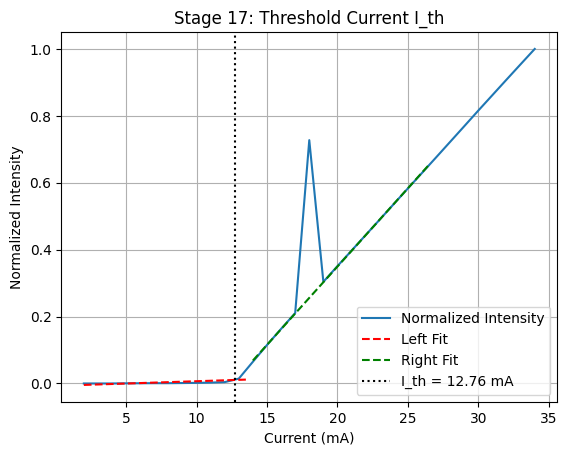

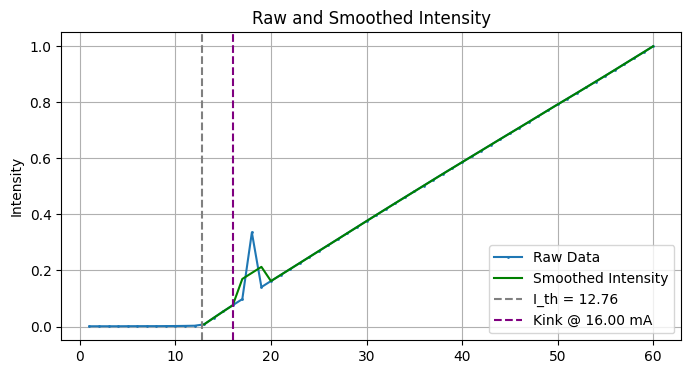

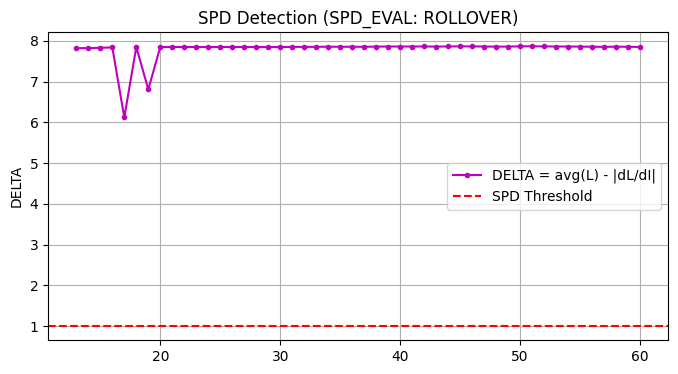

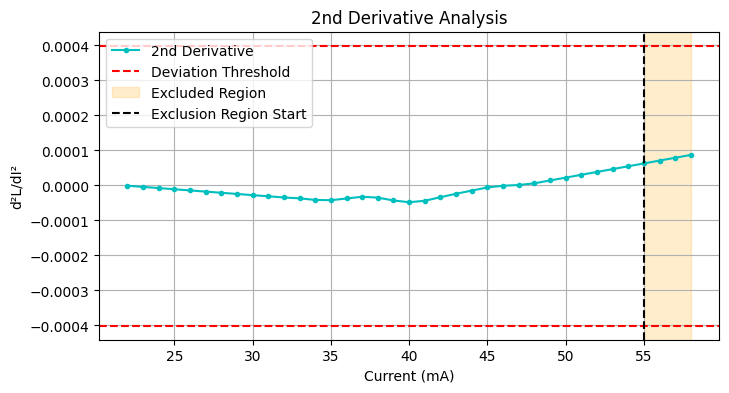

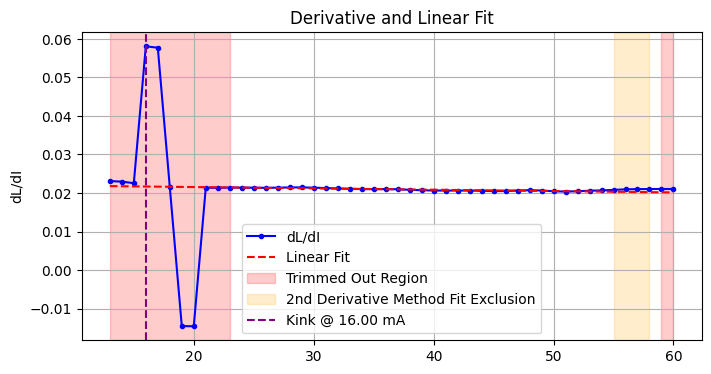

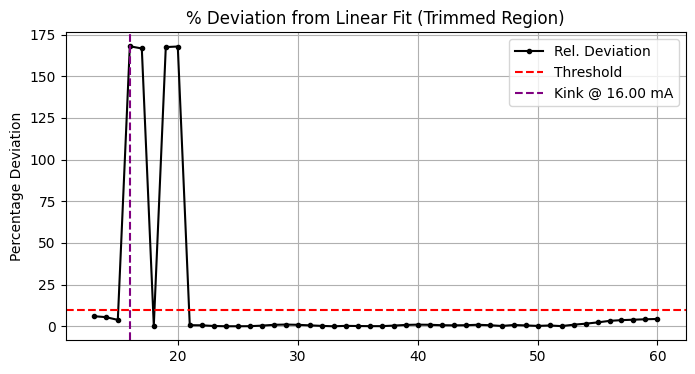

[QCHUH | TD 309924] KINK: 16.000 mA


In [28]:
debug_wafers = ["QCHUH"]
debug_touchdowns = [[309924]]

wafer_records, missing_wafers = liv_raw_filelink_finder(debug_wafers, GTX_URL, ["QC"], select_earliest=False)

file_urls = [w["file_url"] for w in wafer_records]
debug_wafers = [w["wafer_code"] for w in wafer_records]
machine_codes = [w["machine"] for w in wafer_records]

for debug_wafer_code, touchdown_list, debug_file_url, machine_code in zip(
    debug_wafers, debug_touchdowns, file_urls, machine_codes
):
    product_code = debug_wafer_code[:2]
    if product_code == "QD" or "NV":
        decoder_path = ROOT_DIR / "decoders" / HALO_DECODER
    else:
        decoder_path = ROOT_DIR / "decoders" / SUBARU_DECODER
        continue

    df_raw_sweeps = get_raw_sweeps_for_laser(
        debug_file_url, debug_wafer_code, machine_code, decoder_path, touchdown_list
    )
    for td in touchdown_list:
        device_data = df_raw_sweeps[df_raw_sweeps["TOUCHDOWN"] == td]
        if device_data.empty:
            print(f"⚠️ No data found for TOUCHDOWN {td} on wafer {wafer_code}")
            continue

        device_data = flag_no_laser_touchdowns(device_data)
        no_laser = (device_data["FLAG"] == "NO LASER").all()
        if no_laser:
            print(f"⚠️ No laser detected for TOUCHDOWN {td} on wafer {debug_wafer_code}. Skipping analysis.")
            continue

        current = device_data["LDI_mA"].values
        intensity = device_data["PD"].values
        voltage = device_data["Vf"].values

        # Debug analysis
        ith = find_ith_value_labview_debug(intensity, current)
        print(f"[{debug_wafer_code} | TD {td}] I_th: {ith:.3f} mA")

        se = find_slope_efficiency(intensity, current, ith) if ith else 0
        print(f"[{debug_wafer_code} | TD {td}] SE: {se:.3f} mW/mA")

        rs = find_series_resistance(voltage, current, ith) if ith else 0
        print(f"[{debug_wafer_code} | TD {td}] RS: {rs:.3f} Ohms")

        kink, spd = find_spd_kink_debug(intensity, current, ith) if ith else 0
        print(f"[{debug_wafer_code} | TD {td}] KINK: {kink:.3f} mA")

Loop Requiring raw_sweeps_tables to be populated from the legacy transform cell:

In [29]:
USE_REAL_DEVICE = True  # Toggle this to switch modes
WAFER_ID_INPUT = "QCHX8"  # Set this to your target wafer ID
TOUCHDOWN_INPUT = 21 * 10000  # Set this to your target touchdown number

if USE_REAL_DEVICE:
    print("🔍 Extracting one specific device from raw_sweeps_tables...")

    # Find the raw_sweeps table matching the wafer ID
    matching_table = None
    for table in raw_sweeps_tables:
        if table["WAFER_ID"].iloc[0] == WAFER_ID_INPUT:
            matching_table = table
            break

    if matching_table is None:
        raise ValueError(f"❌ No table found with WAFER_ID = {WAFER_ID_INPUT}")

    # Filter the table for the selected TOUCHDOWN
    device_data = matching_table[matching_table["TOUCHDOWN"] == TOUCHDOWN_INPUT]

    if device_data.empty:
        raise ValueError(f"❌ No data found for TOUCHDOWN = {TOUCHDOWN_INPUT} in WAFER_ID = {WAFER_ID_INPUT}")

    # Extract current and intensity (PD) values
    current = device_data["LDI_mA"].values
    intensity = device_data["PD"].values
    voltage = device_data["Vf"].values

else:
    print("🔍 Reading sample raw LI data from CSV...")

    SAMPLE_FILE_PATH = ROOT_DIR / "validation" / "SAMPLE_RAW_CURVES.csv"
    df = pd.read_csv(SAMPLE_FILE_PATH, skipinitialspace=True)
    df.columns = df.columns.str.strip()

    current = df["CURRENT_A"].values * 1e3  # Convert from A to mA
    intensity = df["PD_W"].values

# ✅ Common fitting logic
ith = find_ith_value_labview(intensity, current)
print(f"[LabVIEW Method] I_th: {ith:.3f} mA")

# ith_prototype = find_ith_value(intensity, current)
# print(f"[Prototype Method] I_th: {ith_prototype:.3f} mA")

se = find_slope_efficiency_debug(intensity, current, ith) if ith else 0
print(f"[LabVIEW Method] SE: {se:.3f} mW/mA")

rs = find_series_resistance_debug(voltage, current, ith) if ith else 0
print(f"[LabVIEW Method] RS: {rs:.3f} Ohms")

🔍 Extracting one specific device from raw_sweeps_tables...


NameError: name 'raw_sweeps_tables' is not defined